Data set: TAQ Consolidated Trades from WRDs, 01May2016 to 05May2016, Top Ten tech tickers in SP500

http://cs229.stanford.edu/proj2012/ShahDaiZhong-AutomatedStockTradingUsingMachineLearningAlgorithms.pdf

In [1]:
import os
from scipy import misc
from matplotlib import pyplot as plt
from datetime import timedelta, date
import multiprocessing as mp
import numpy as np
import pandas as pd
from datetime import datetime
from sklearn import decomposition
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Ridge
from sklearn import metrics

#!pip install keras

print("Number of processors: ", mp.cpu_count())
%matplotlib inline

Number of processors:  12


In [2]:
data = pd.read_csv('171731d702aa6fcd.csv', parse_dates=[['DATE', 'TIME_M']])
data = data.drop(['SYM_SUFFIX'], axis=1)
data.columns = ['time', 'symbol', 'vol', 'price']
print(data.dtypes)

time      datetime64[ns]
symbol            object
vol                int64
price            float64
dtype: object


In [3]:
symbol_list = data['symbol'].unique()
symbol_list

array(['AAPL', 'ADBE', 'CRM', 'CSCO', 'INTC', 'MA', 'MSFT', 'NVDA',
       'PYPL', 'V'], dtype=object)

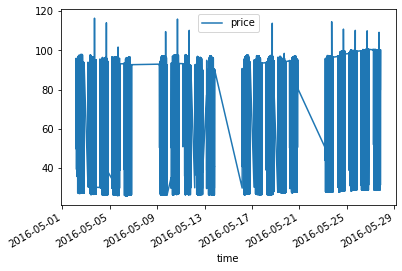

In [4]:
data.plot(x='time', y='price')

## Plot day to day data per symbol

symbol
AAPL    AxesSubplot(0.125,0.2;0.775x0.68)
ADBE    AxesSubplot(0.125,0.2;0.775x0.68)
CRM     AxesSubplot(0.125,0.2;0.775x0.68)
CSCO    AxesSubplot(0.125,0.2;0.775x0.68)
INTC    AxesSubplot(0.125,0.2;0.775x0.68)
MA      AxesSubplot(0.125,0.2;0.775x0.68)
MSFT    AxesSubplot(0.125,0.2;0.775x0.68)
NVDA    AxesSubplot(0.125,0.2;0.775x0.68)
PYPL    AxesSubplot(0.125,0.2;0.775x0.68)
V       AxesSubplot(0.125,0.2;0.775x0.68)
dtype: object

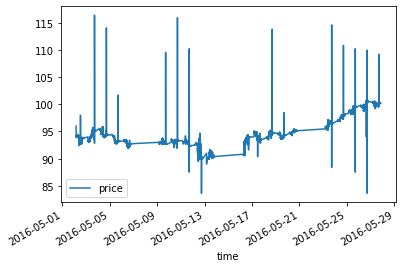

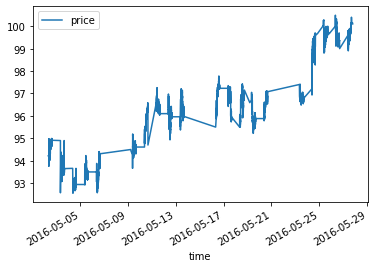

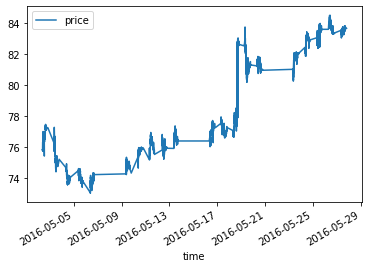

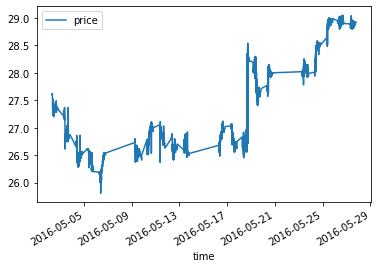

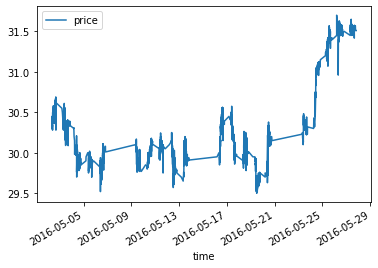

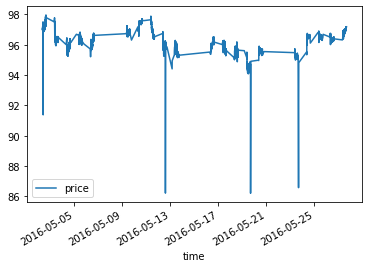

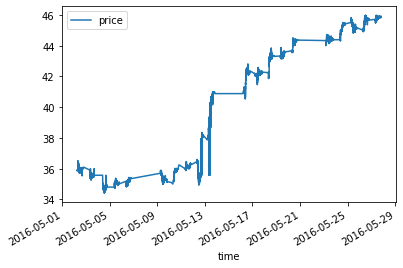

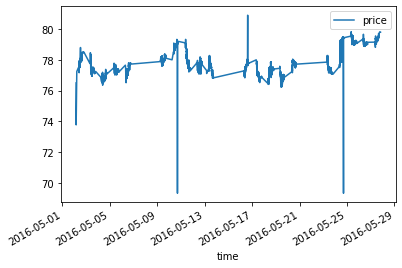

In [5]:
data.groupby(['symbol']).plot(x='time', y='price')

## Bin data
- split pandas data set by symbol, then by day
- perform initial analysis over one symbol

In [16]:
price_by_symbol = dict(iter(data.groupby('symbol')))
aapl = price_by_symbol['MA']

In [19]:
plt.figure(figsize=(20,10))
aapl.plot(x='time', y='price', title='MA, May 2016')
plt.savefig('MA_price_time.png')

<Figure size 1440x720 with 0 Axes>

In [20]:
aapl

time symbol   vol   price
9577472  2016-05-02 08:00:00.020565     MA    52  97.000
9577473  2016-05-02 08:00:02.346357     MA   100  97.000
9577474  2016-05-02 08:00:33.613609     MA    48  97.000
9577475  2016-05-02 09:05:29.871703     MA    25  97.200
9577476  2016-05-02 09:14:12.882480     MA    20  96.975
...                             ...    ...   ...     ...
10033238 2016-05-27 16:18:38.352583     MA  1400  97.180
10033239 2016-05-27 16:28:19.058525     MA  1638  97.180
10033240 2016-05-27 16:29:45.335161     MA   210  97.180
10033241 2016-05-27 16:39:53.043065     MA   200  97.180
10033242 2016-05-27 17:07:30.758369     MA   220  97.180

[455771 rows x 4 columns]

In [21]:
aapl.index = aapl['time']

In [38]:
def bin_data(data, period_start,period_end,time_open,time_close):
    trading_days = pd.bdate_range(start=period_start, end=period_end)
    data_resampled = data.resample('1min').agg({'price': 'ohlc', 'vol': 'sum'})
    data_binned = pd.DataFrame(columns=data_resampled.columns)
    for day in trading_days:
        #pd.concat([data_binned, data[(data.index>=day+time_open) & (data.index<=day+time_close)]])
        data_binned = data_binned.append(data_resampled[(data_resampled.index>=day+time_open) & (data_resampled.index<=day+time_close)])
    return data_binned

In [39]:
#period_start = '2016-05-01'
#period_end = '2016-05-30'


period_start = data['time'].min()
period_end = data['time'].max()
time_open = pd.Timedelta('09:30:00')
time_close = pd.Timedelta('16:00:00')
 
aapl_binned = bin_data(aapl, period_start,period_end,time_open,time_close)

In [47]:
def plot_data(data,period_start,period_end,time_open,time_close, resolution='day'):
    if resolution is 'day':
        trading_days = pd.bdate_range(start=period_start, end=period_end)
        for day in trading_days:
            fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20,10))
            mask = (data.index>=day+time_open) & (data.index<=day+time_close)
            data[mask].plot(y='price', ax=axes[0,0])
            data[mask].plot(y='vol', ax=axes[0,1])
            data[mask].plot(y='price', ax=axes[1,0], kind = 'kde')
            data[mask].plot(y='vol', ax=axes[1,1], kind = 'kde')
            fig.savefig('diff_in_price_kde_{}.png'.format(day.strftime("%d")))
    elif resolution is 'month':
        fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20,10))
        data.plot(y='price', ax=axes[0,0])
        data.plot(y='vol', ax=axes[0,1])
        data.plot(y='price', ax=axes[1,0], kind = 'kde') 
        data.plot(y='vol', ax=axes[1,1], kind = 'kde')
    return

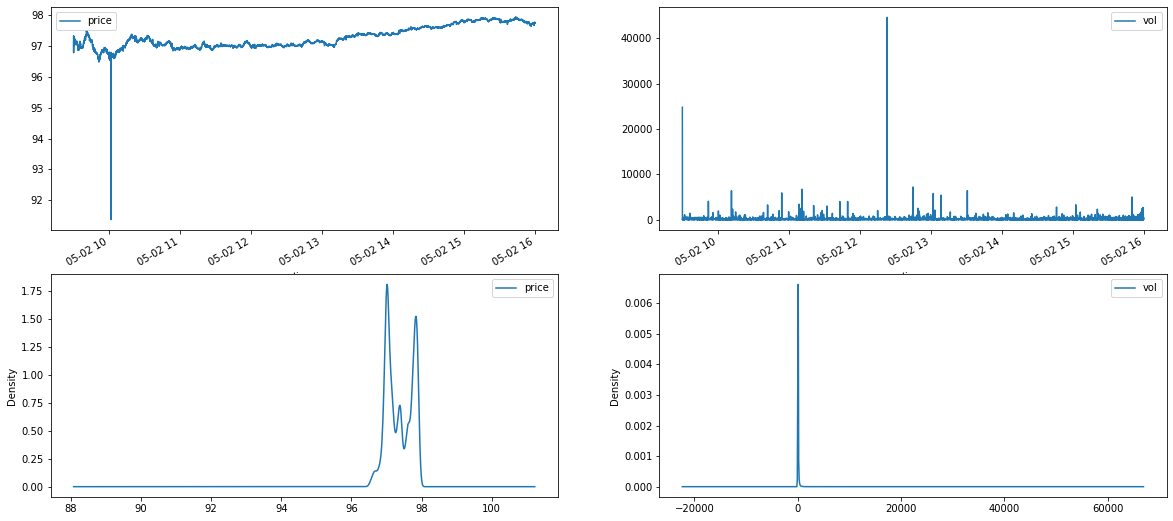

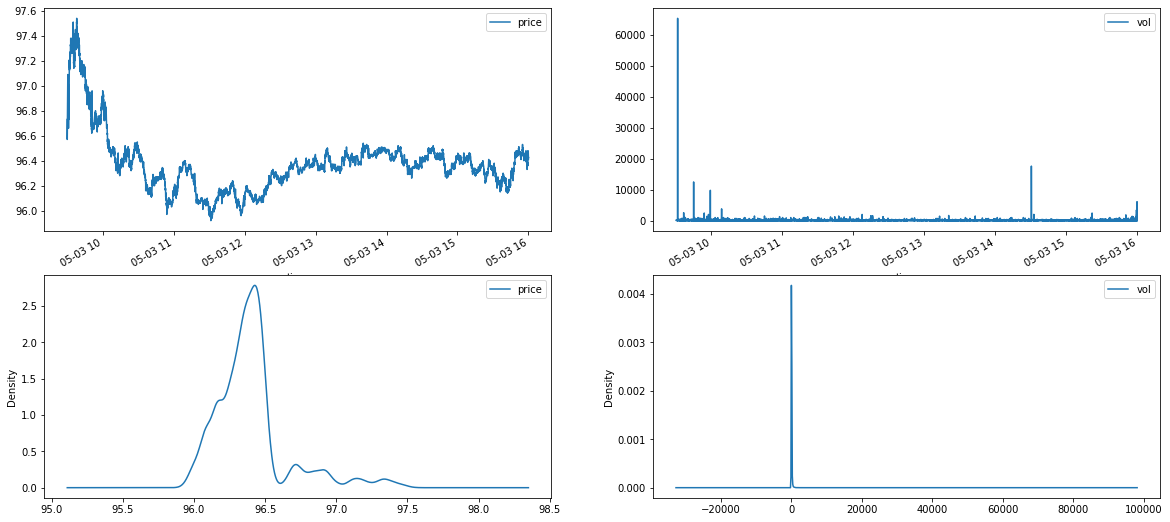

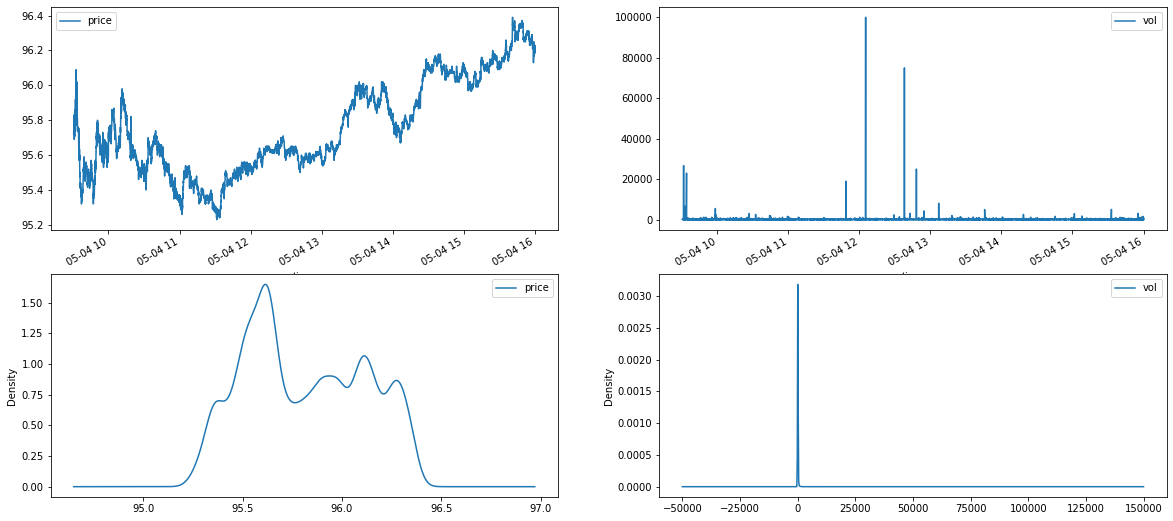

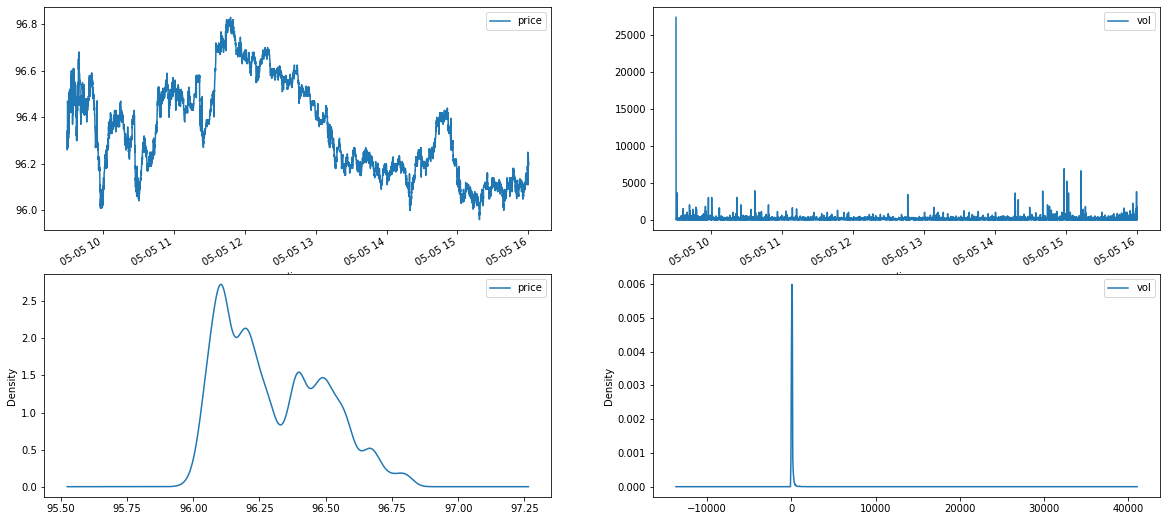

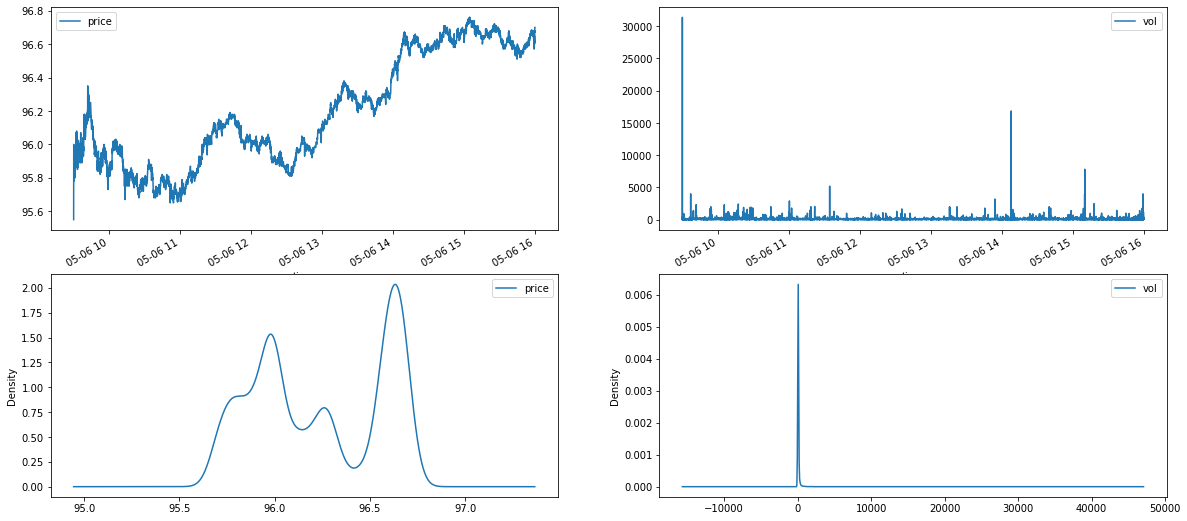

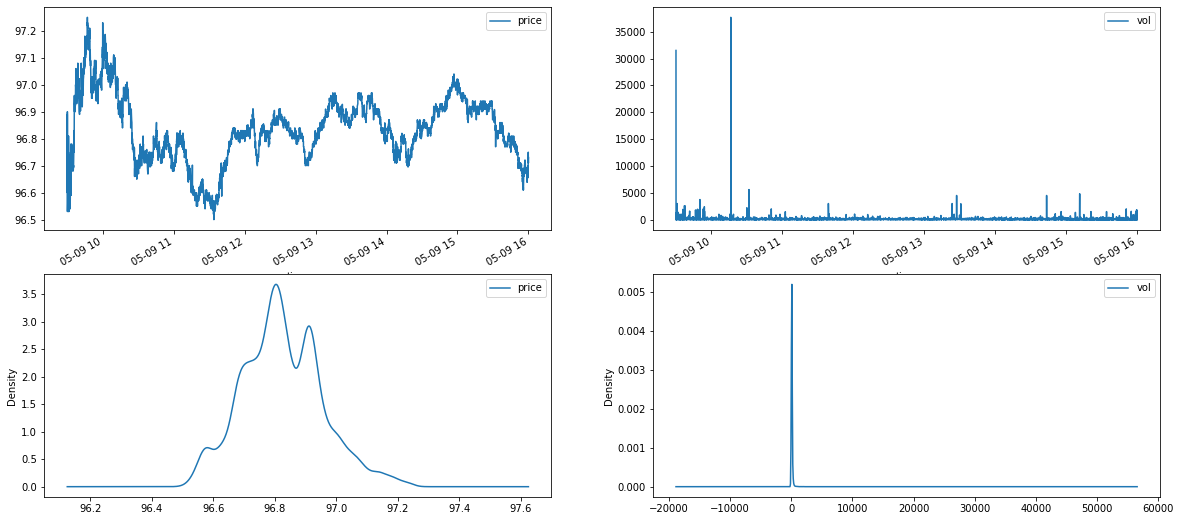

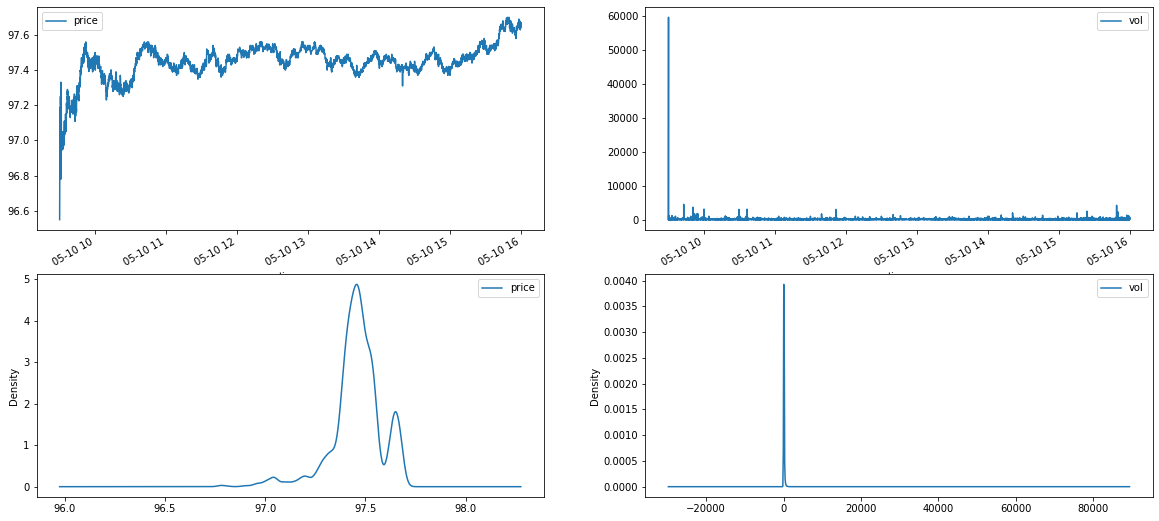

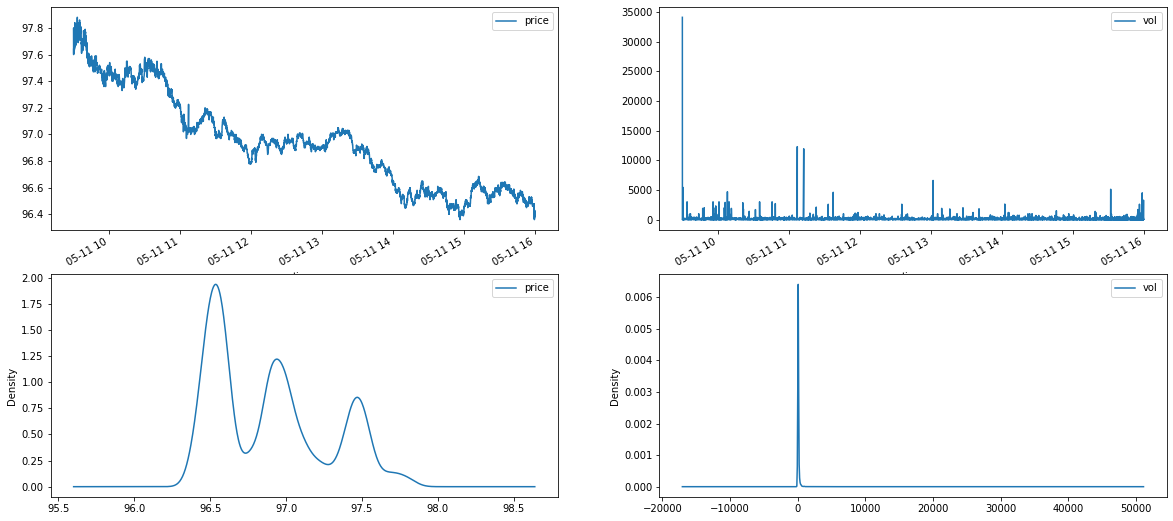

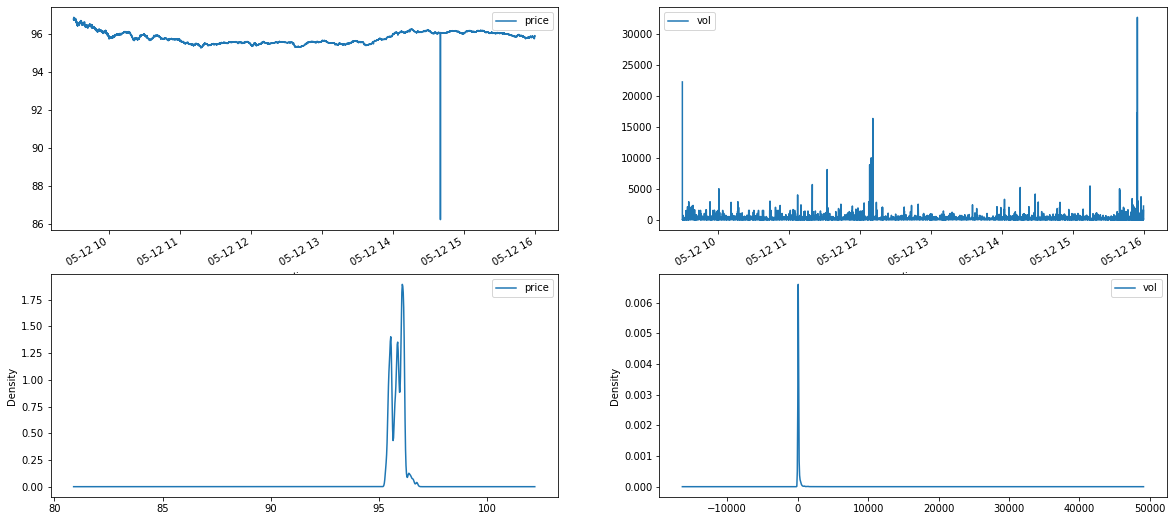

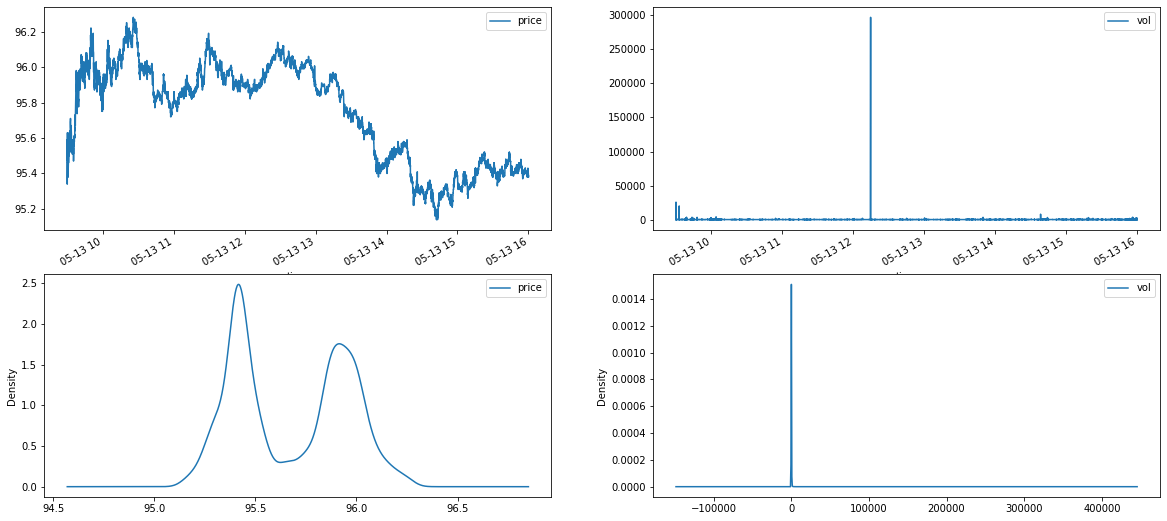

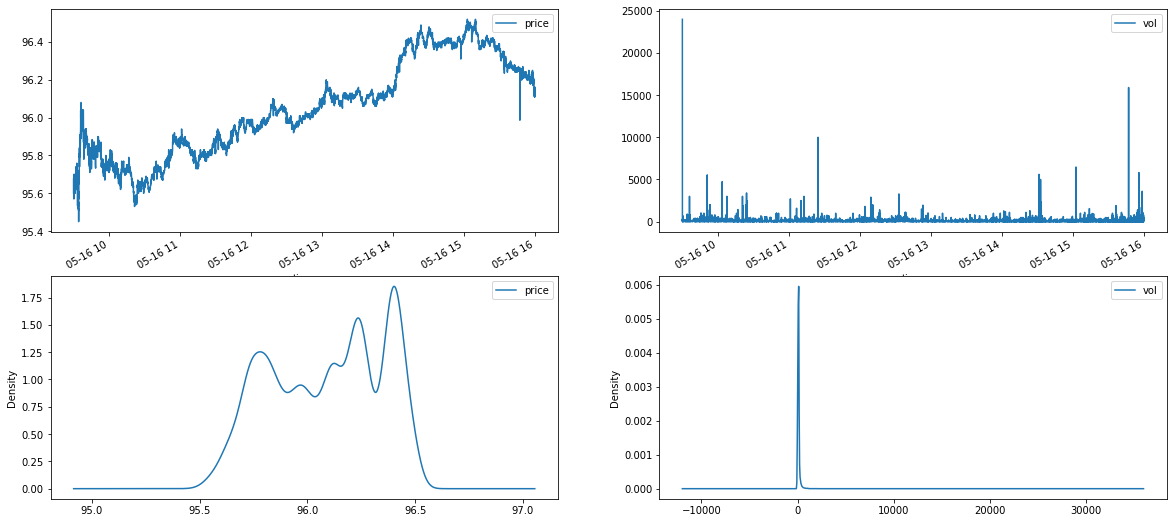

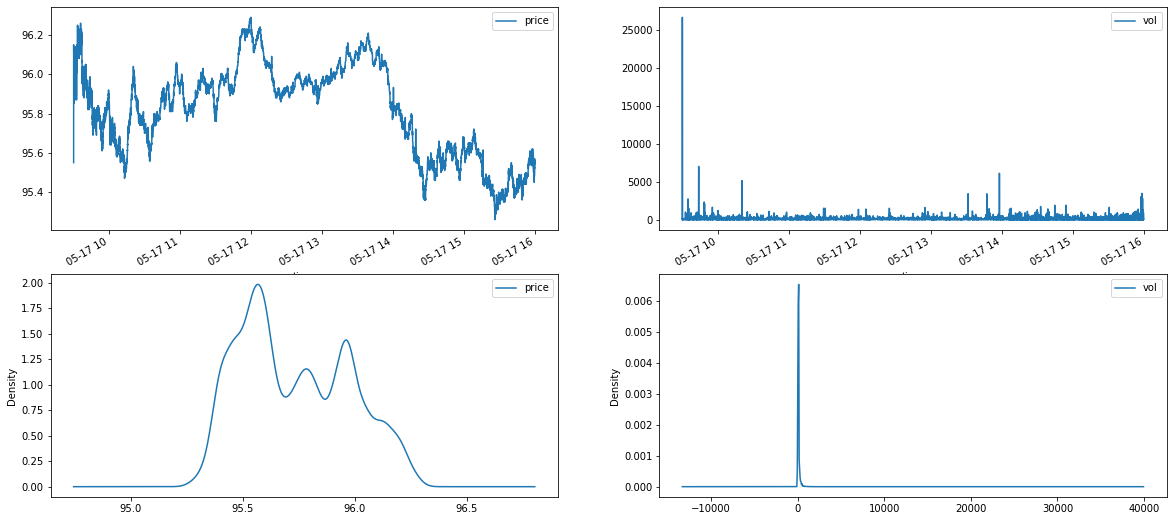

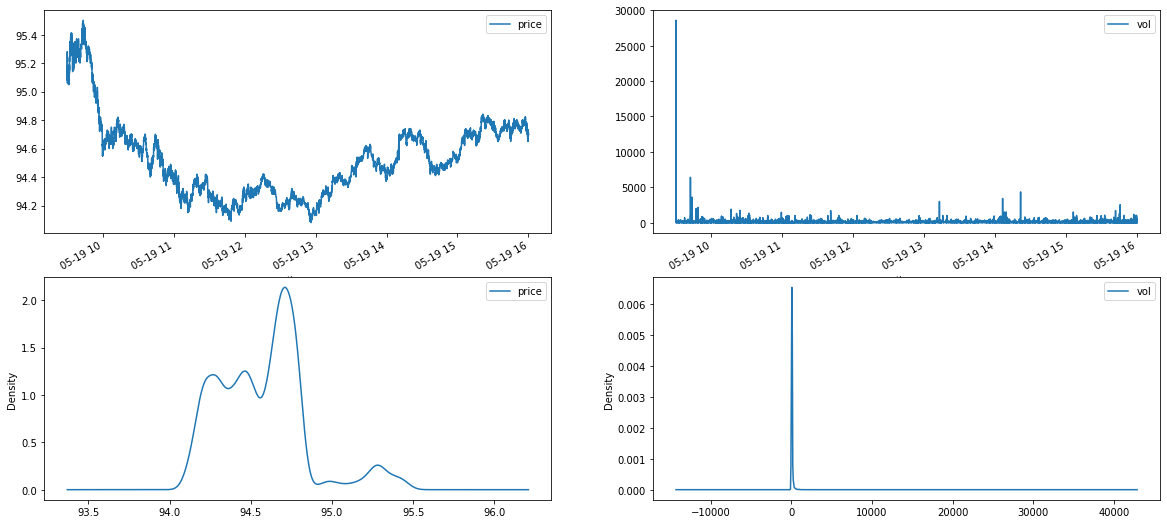

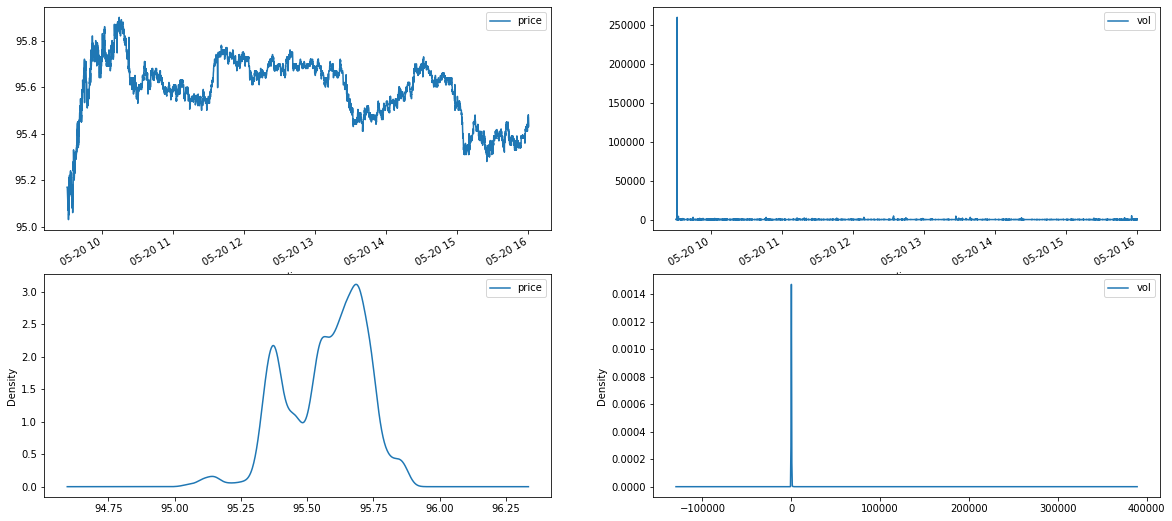

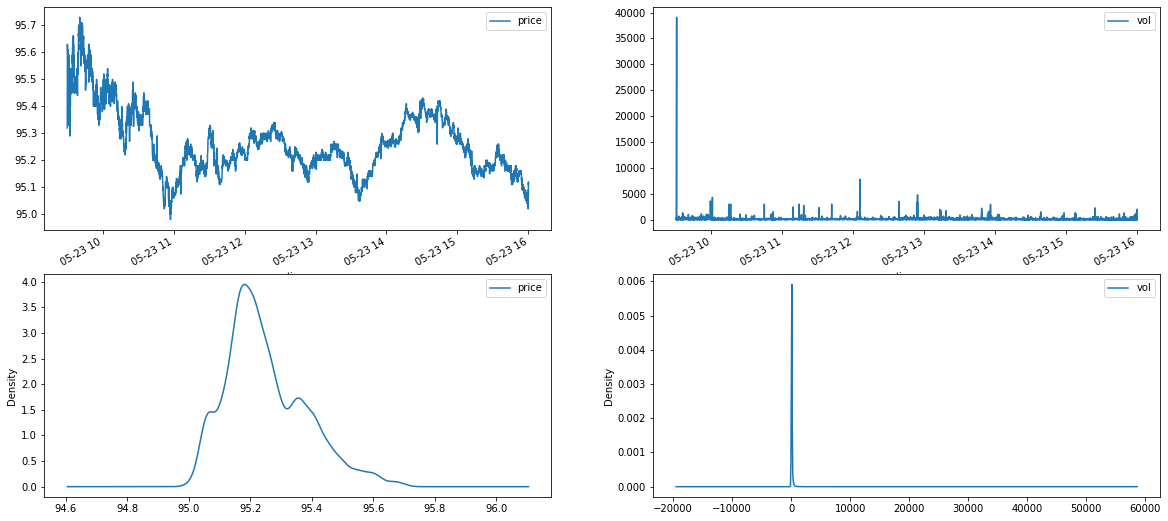

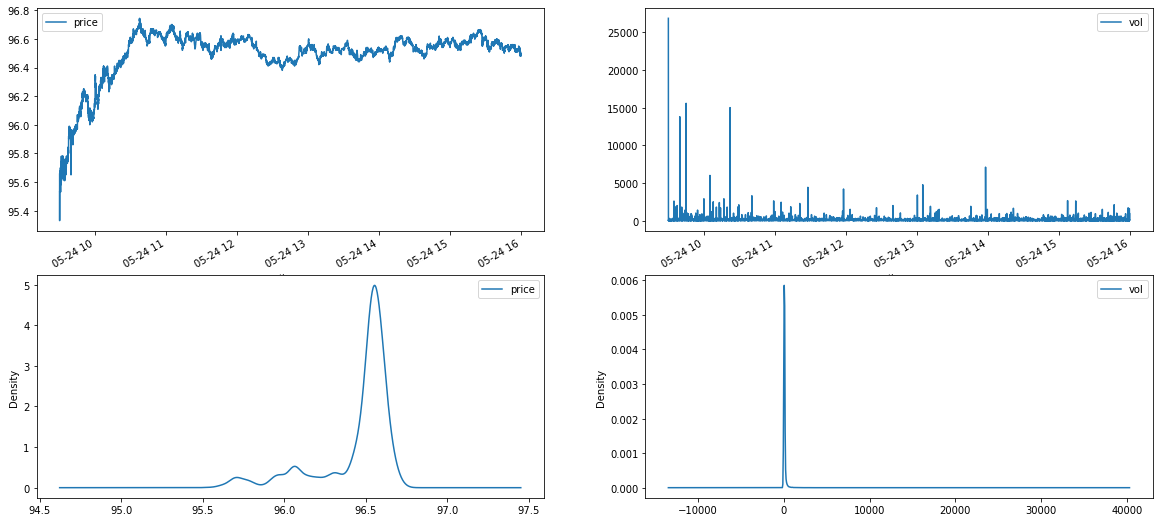

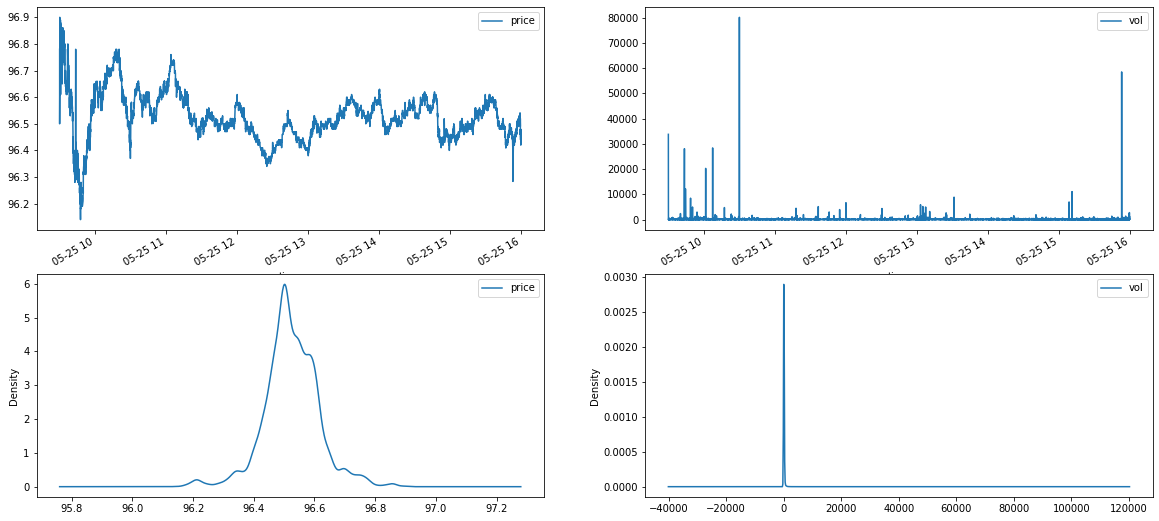

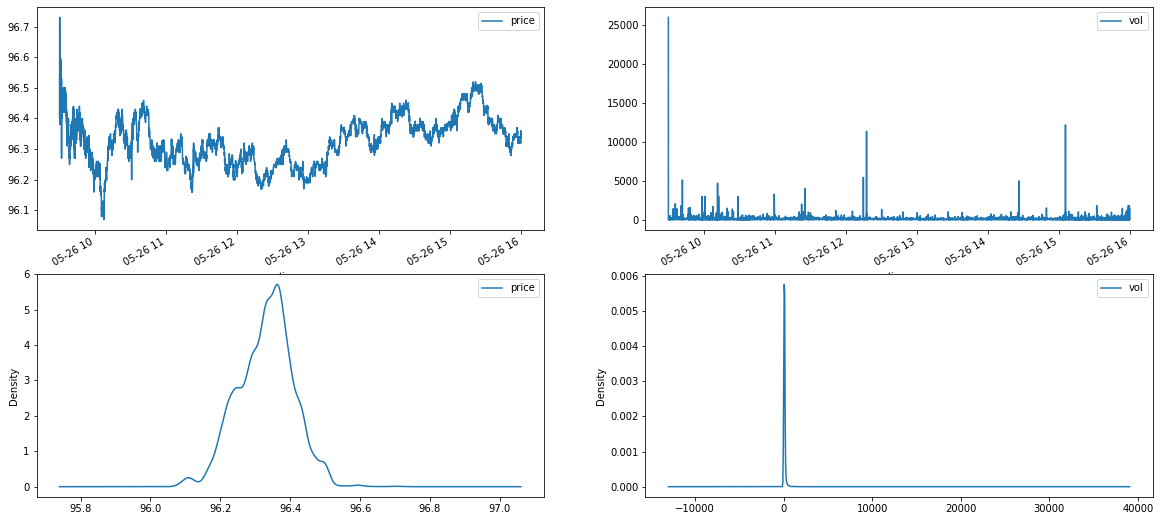

In [32]:
plot_data(aapl,period_start,period_end,time_open,time_close,'day')

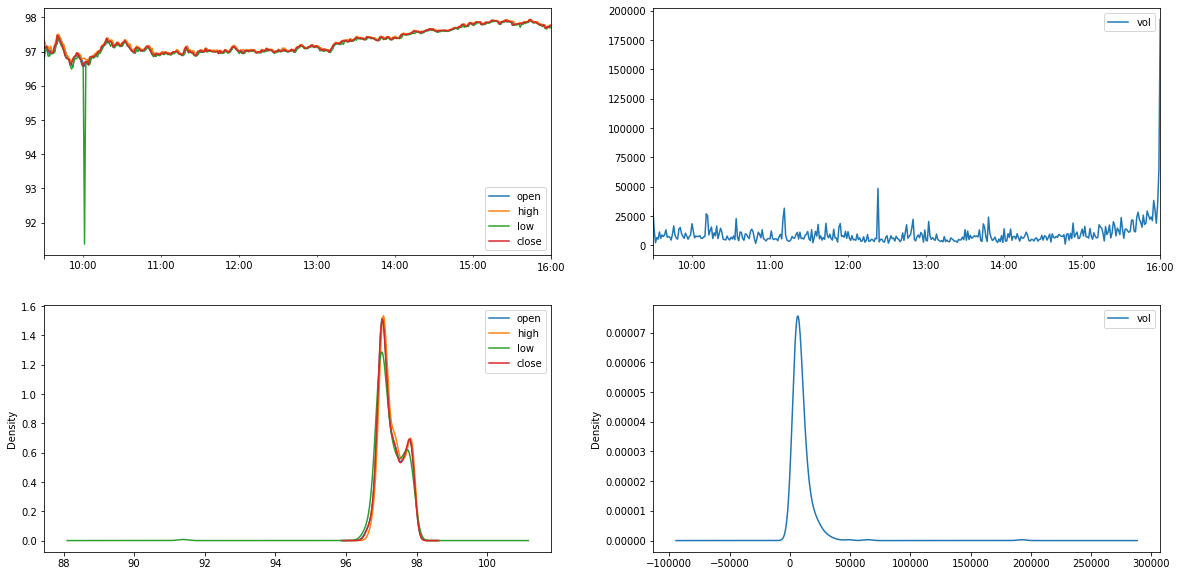

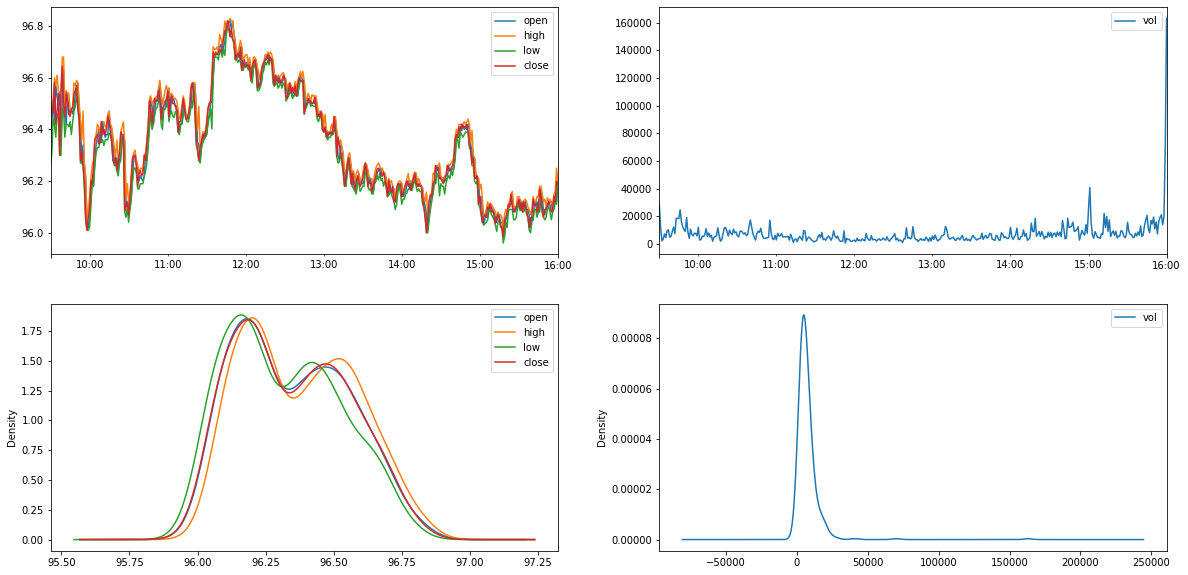

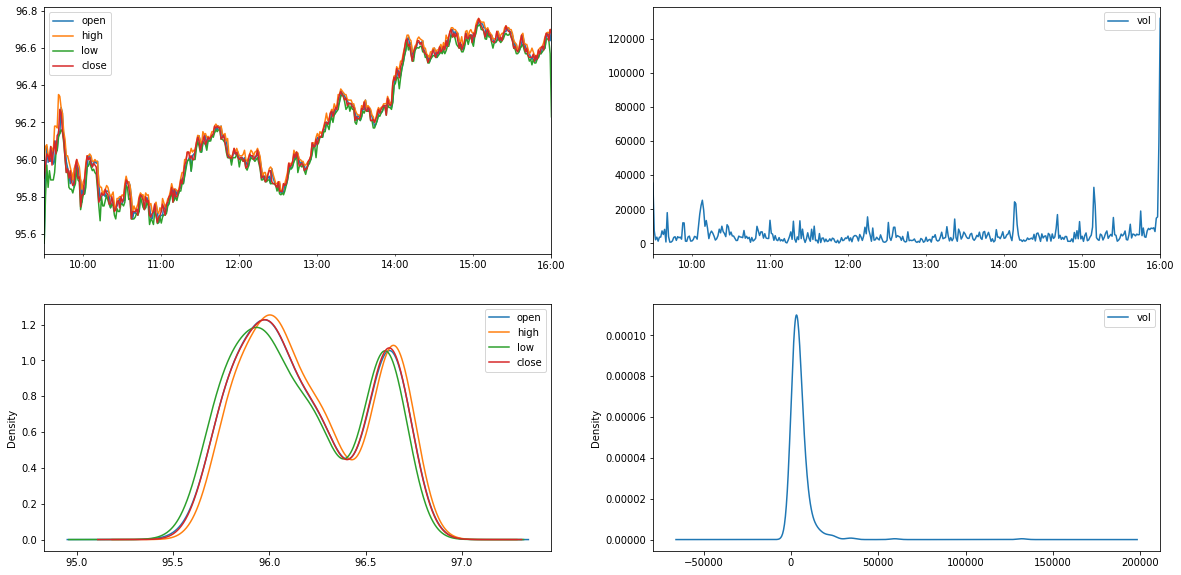

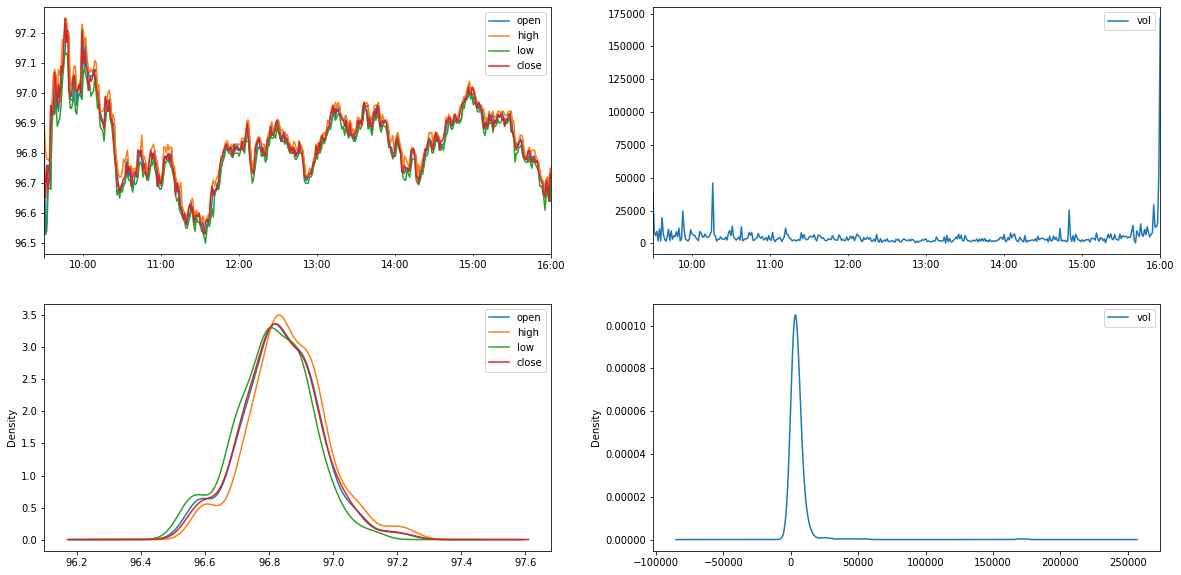

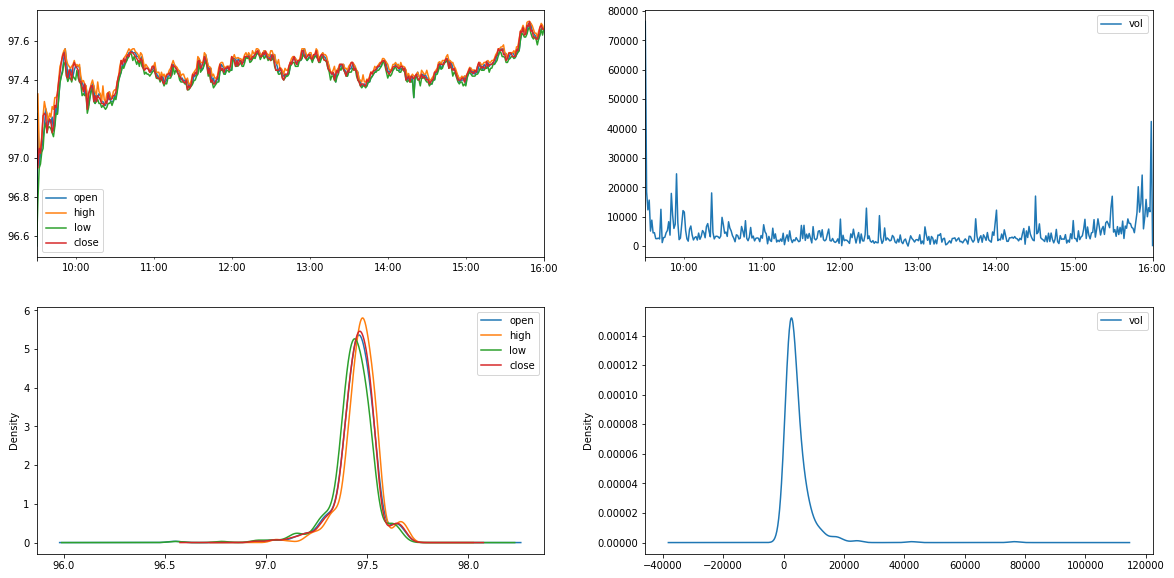

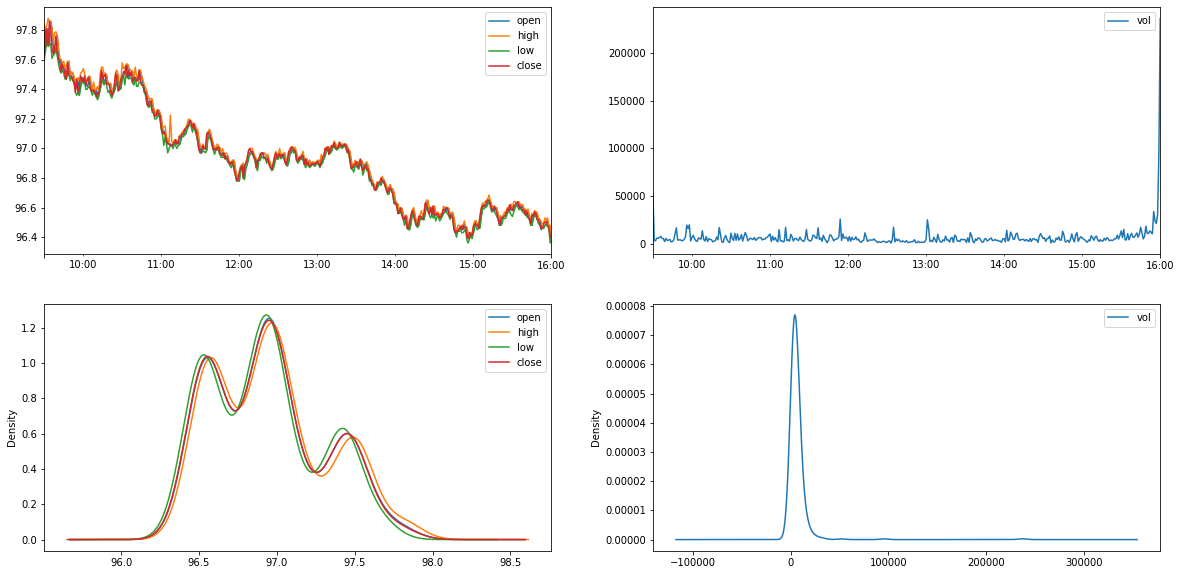

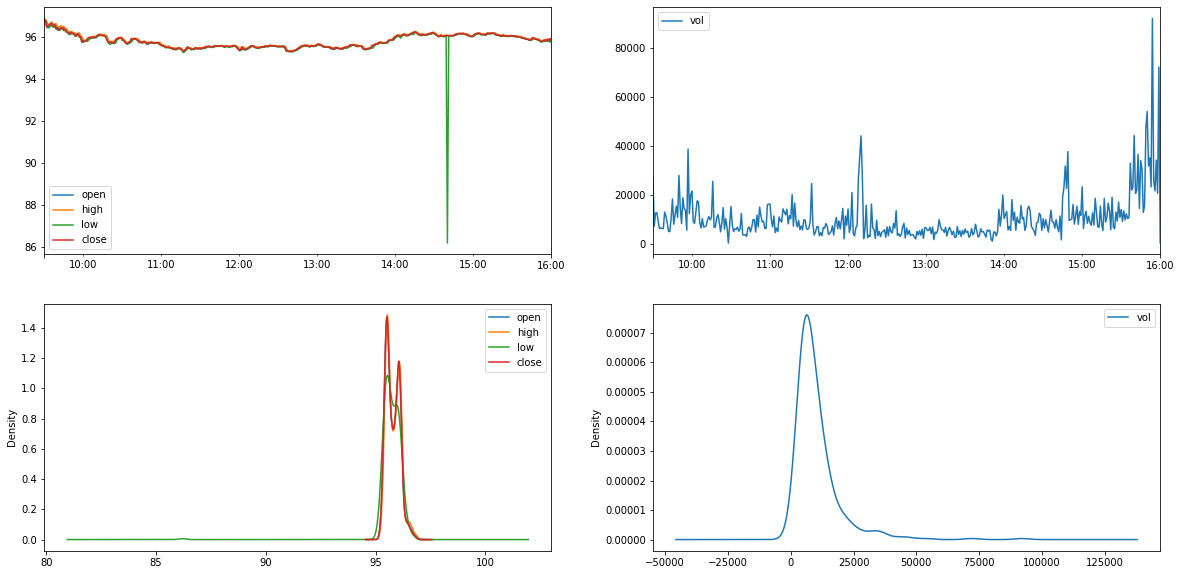

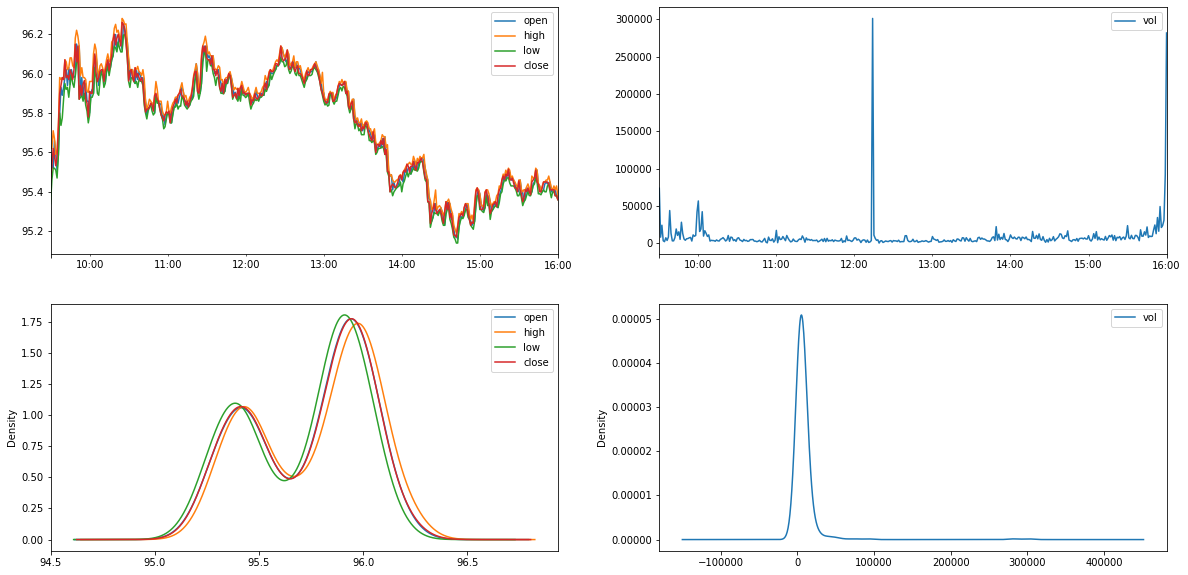

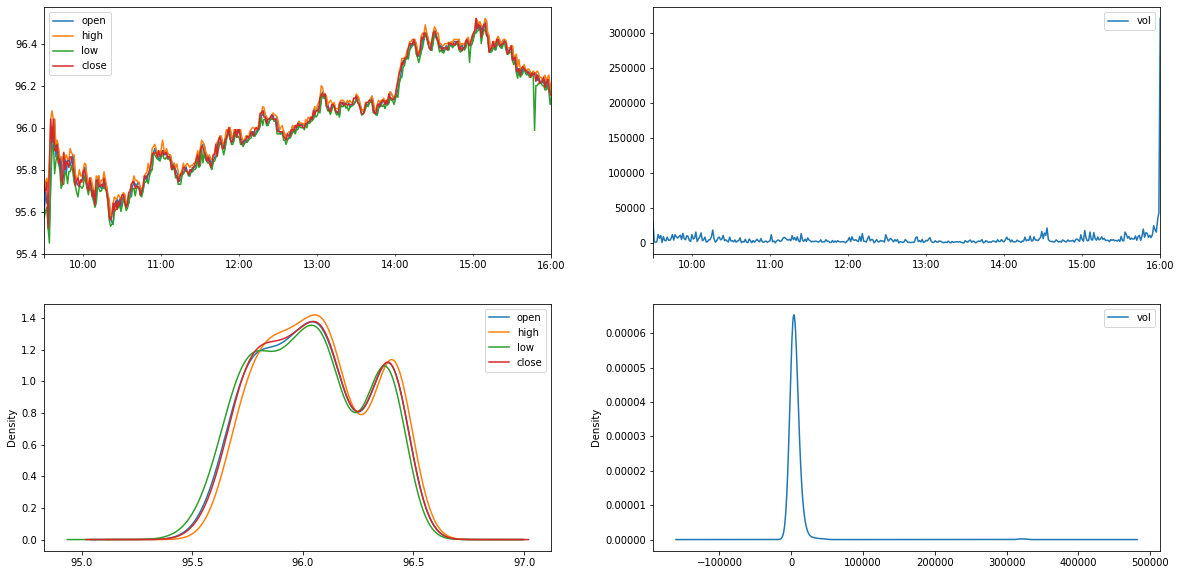

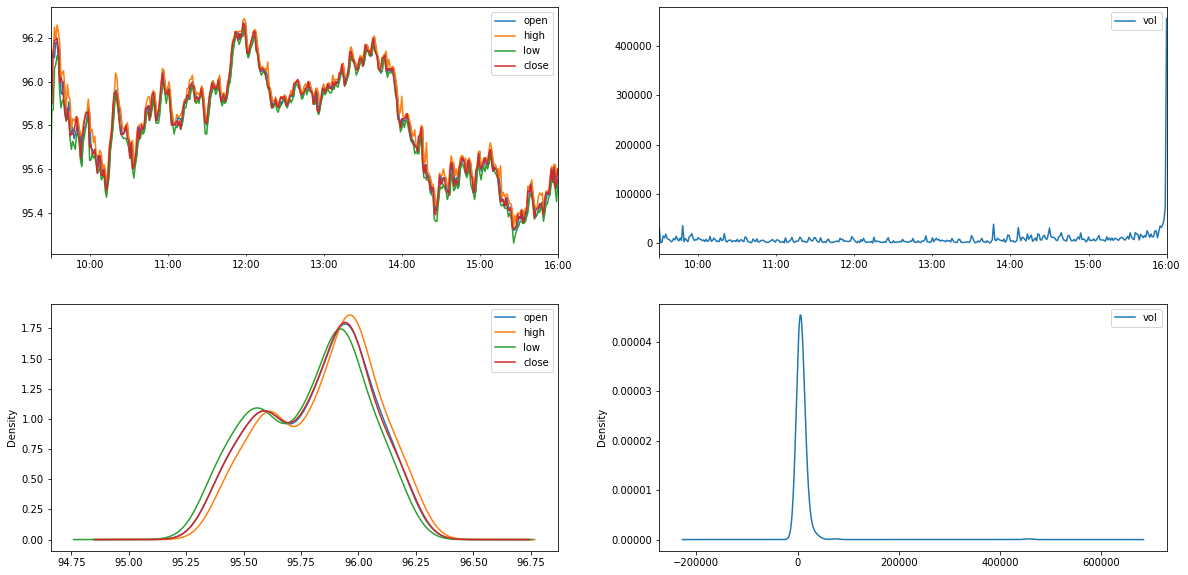

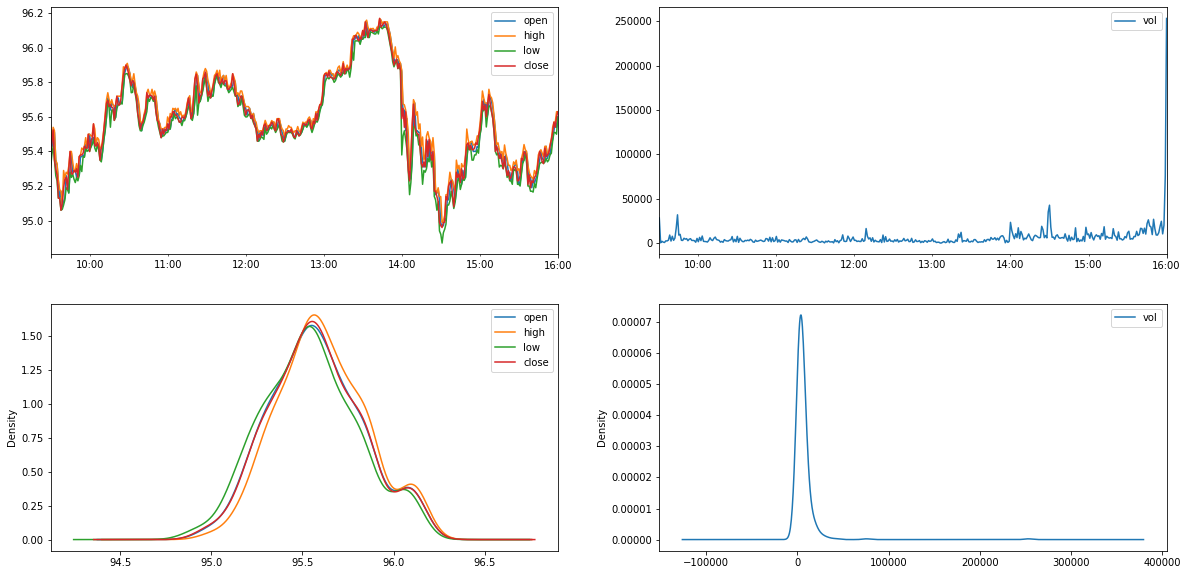

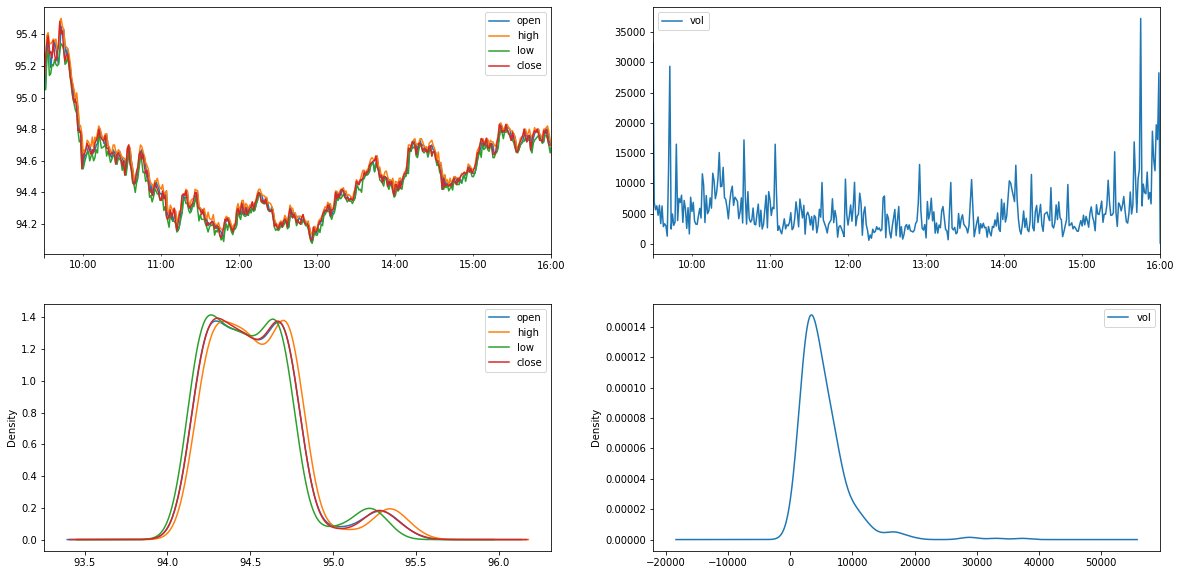

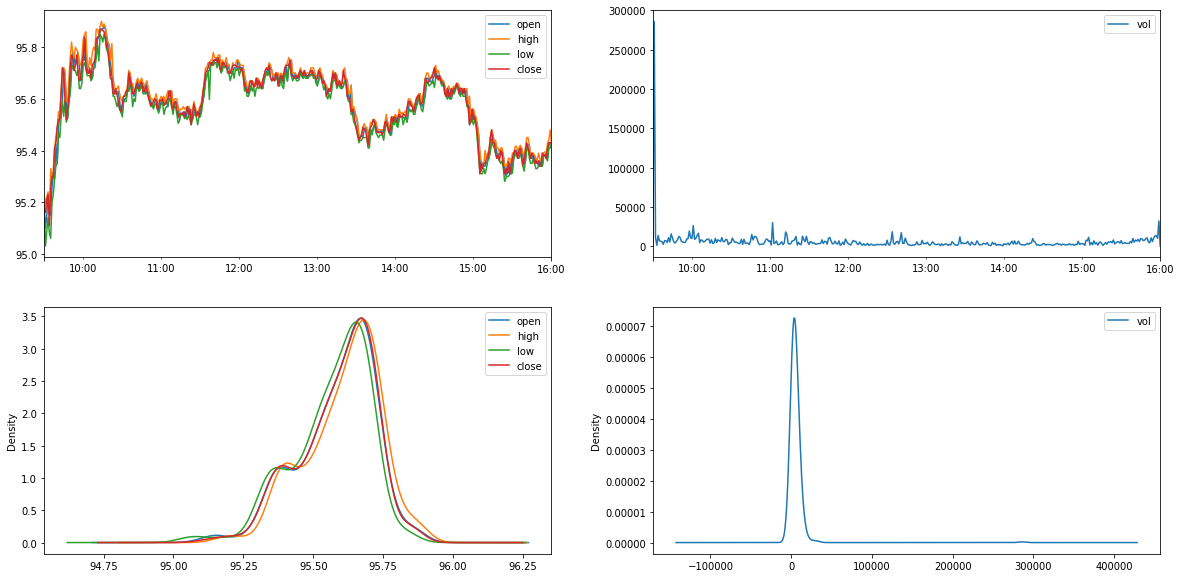

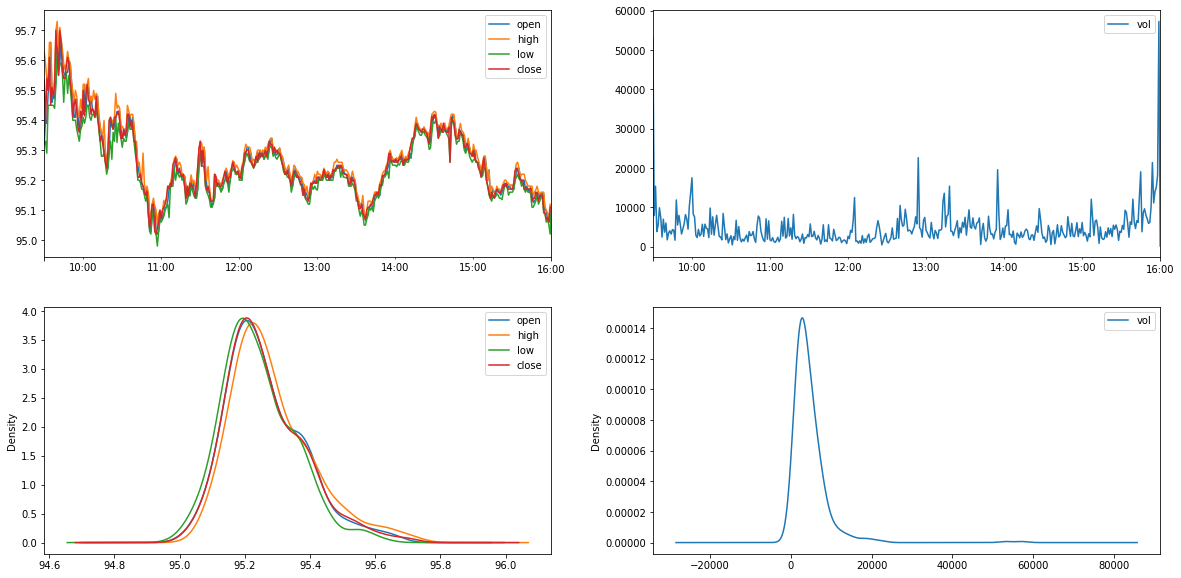

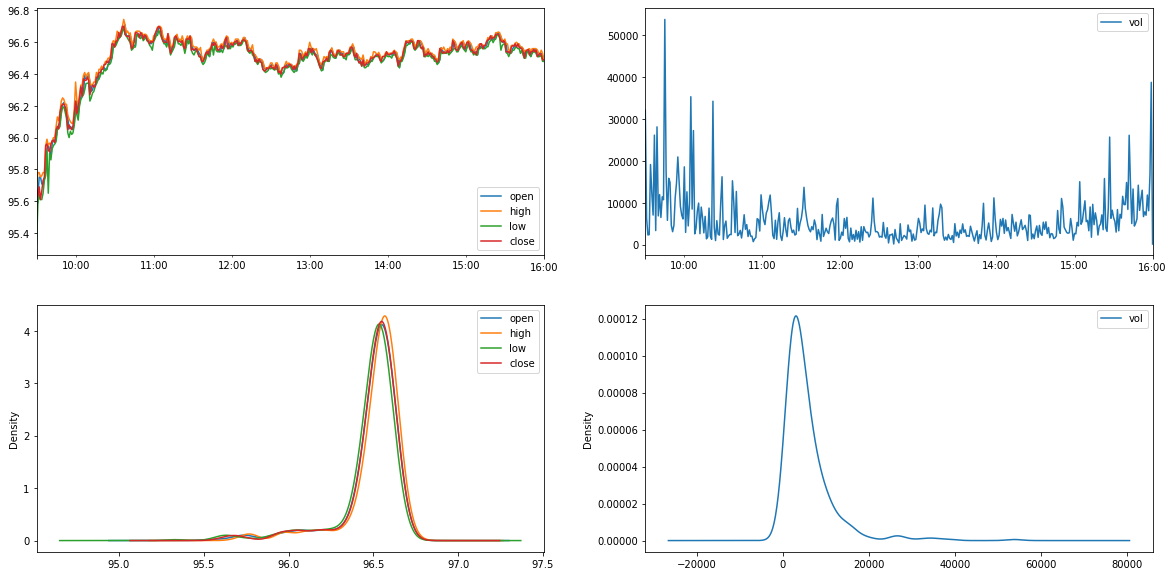

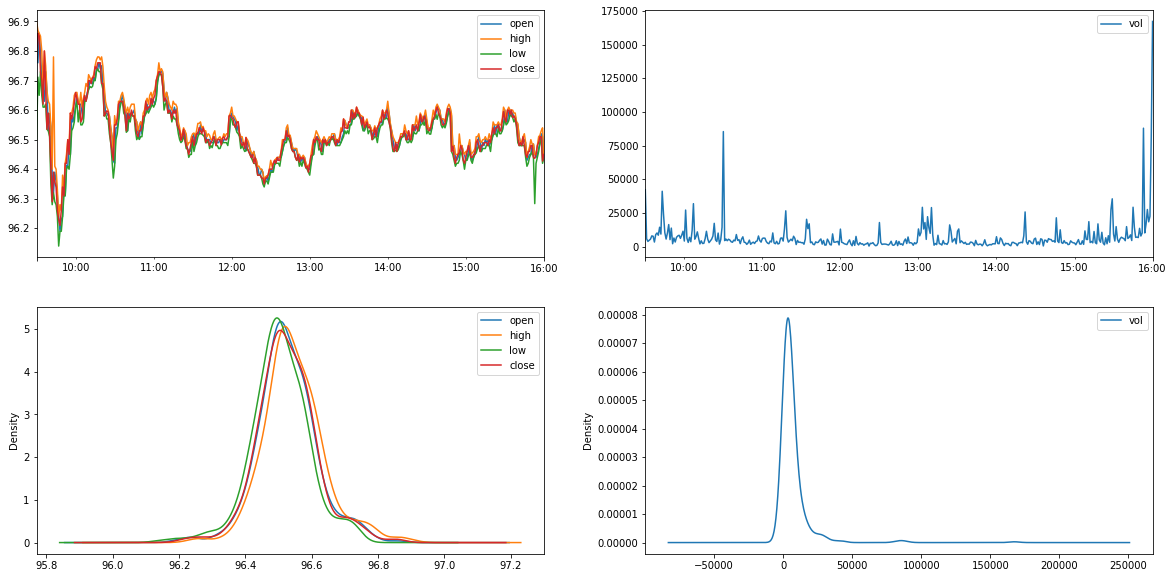

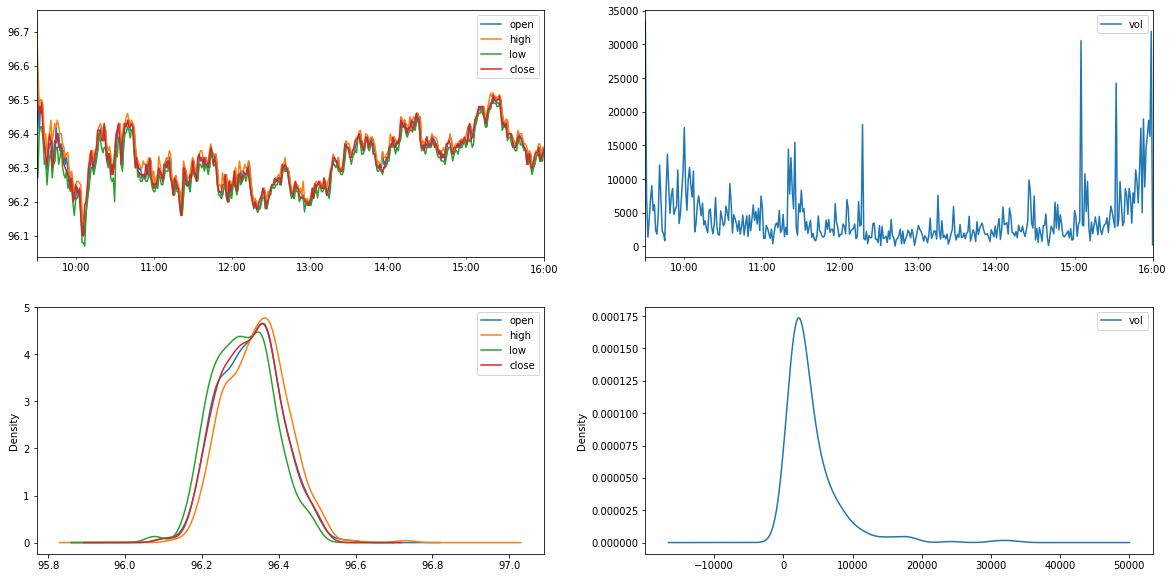

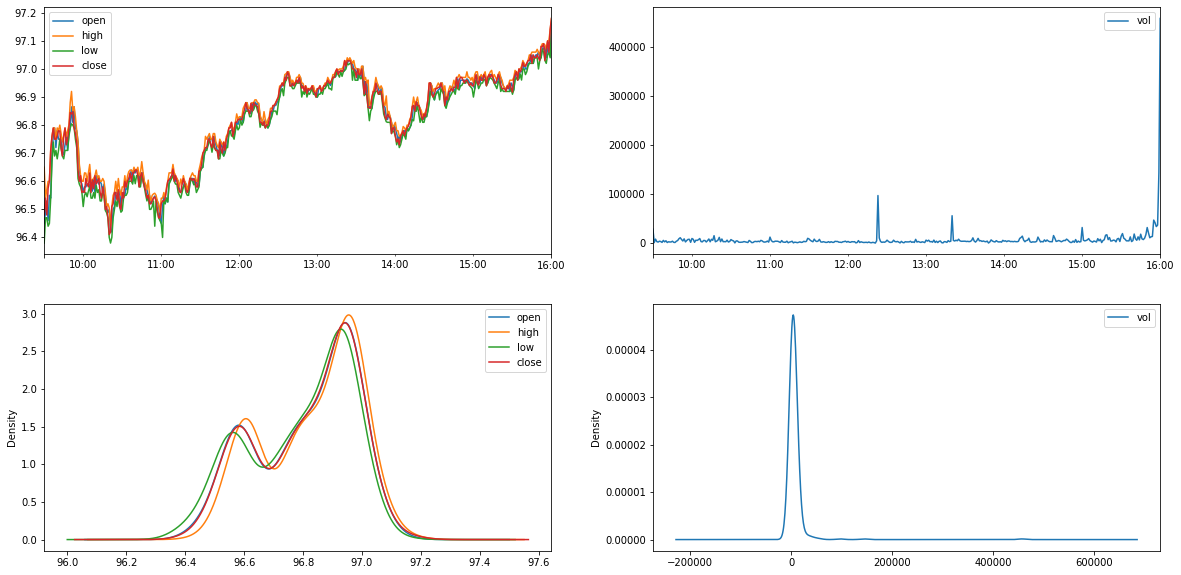

In [46]:
plot_data(aapl_binned,period_start,period_end,time_open,time_close,'day')

## Calculate diff(P_t0, P_t1), diff(V_t0, V_t1)

In [44]:
def delta(data, lambdas=1):
    data_diff = []
    return data.diff(periods=lambdas).divide(data)

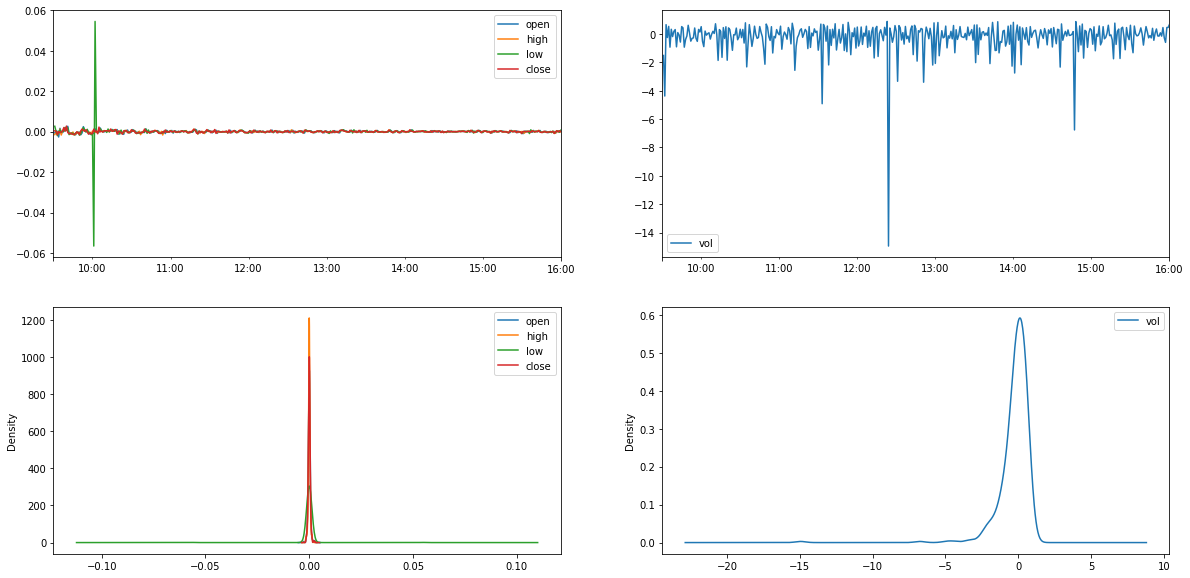

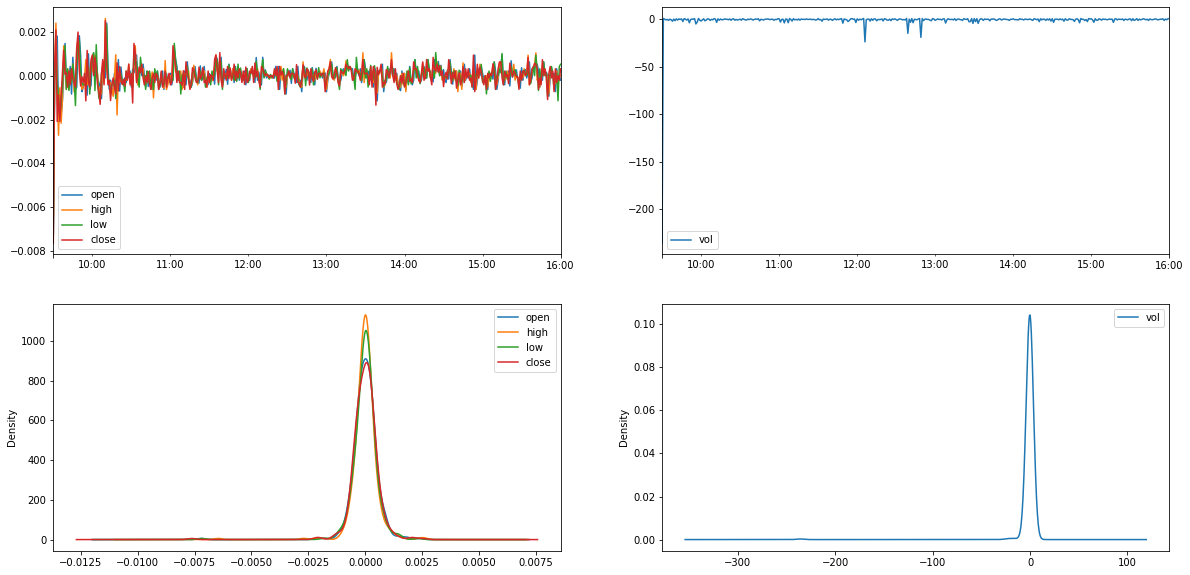

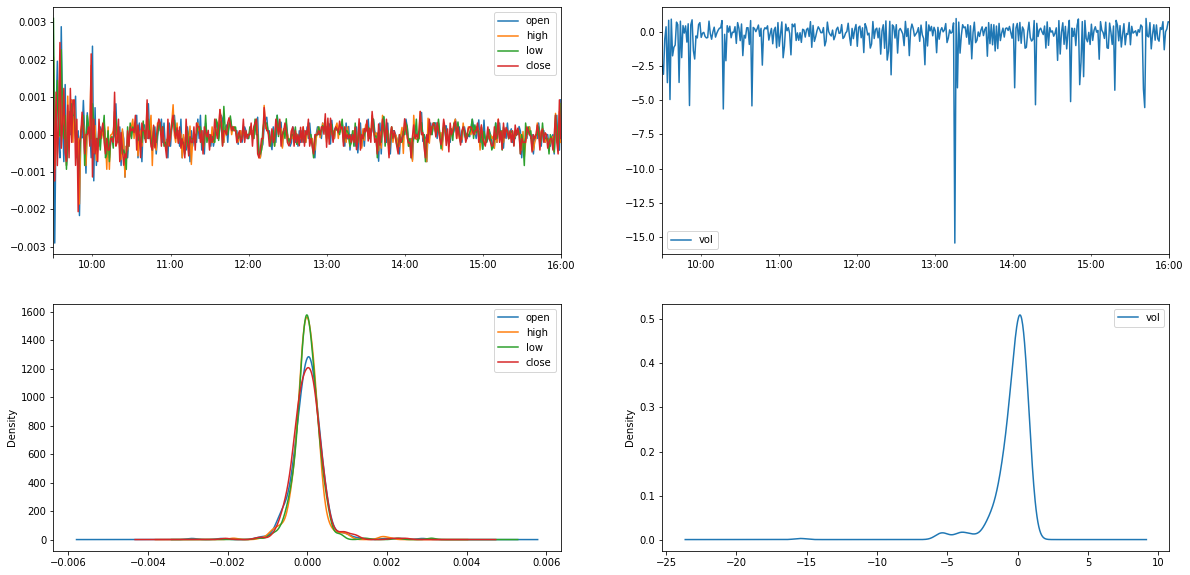

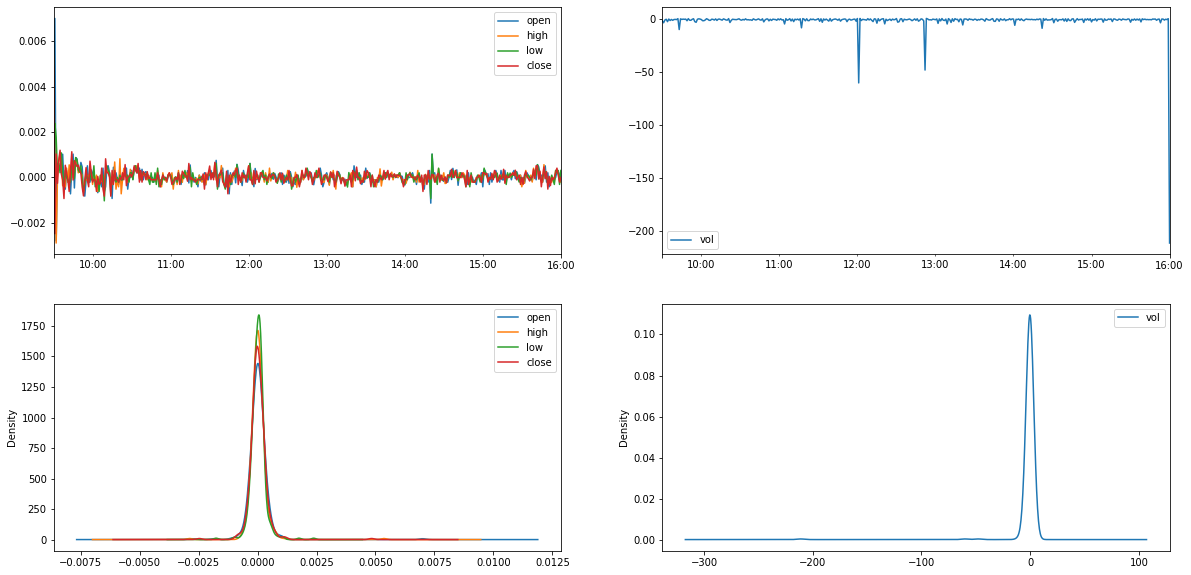

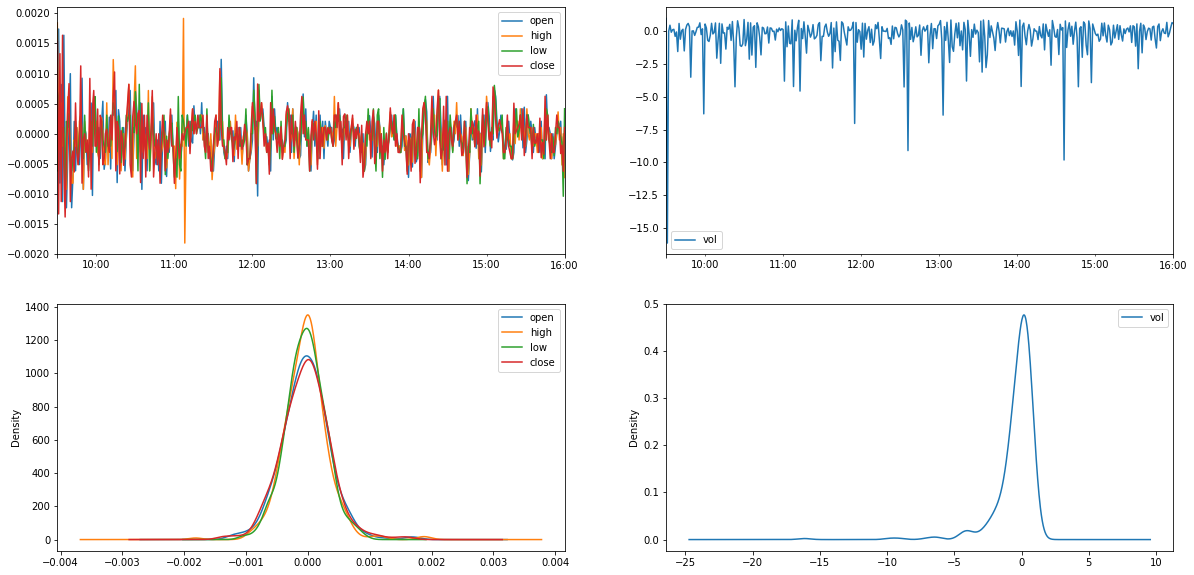

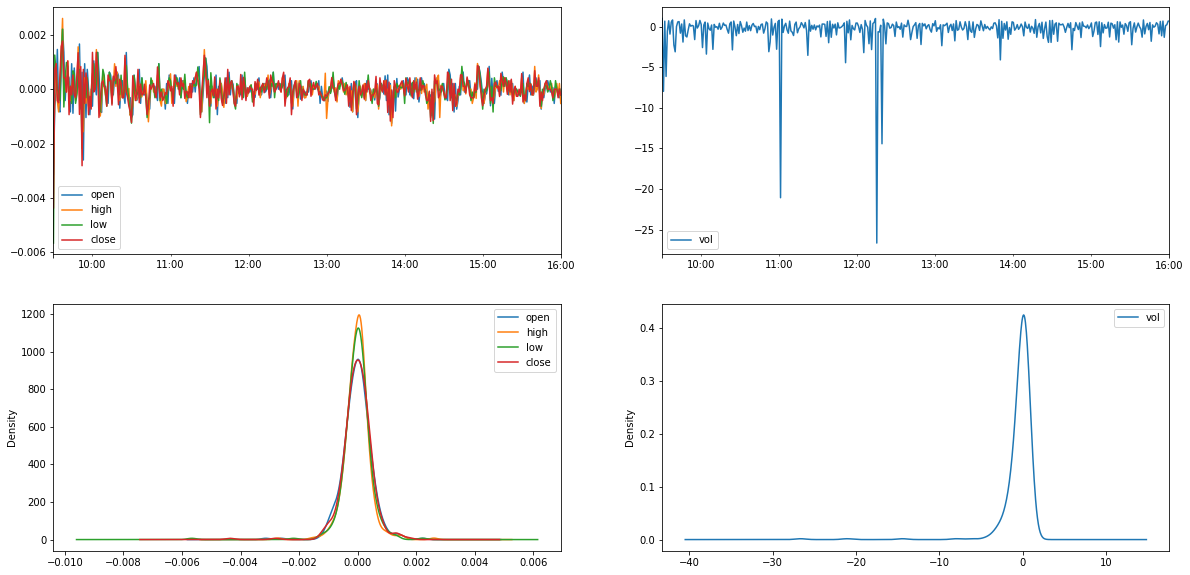

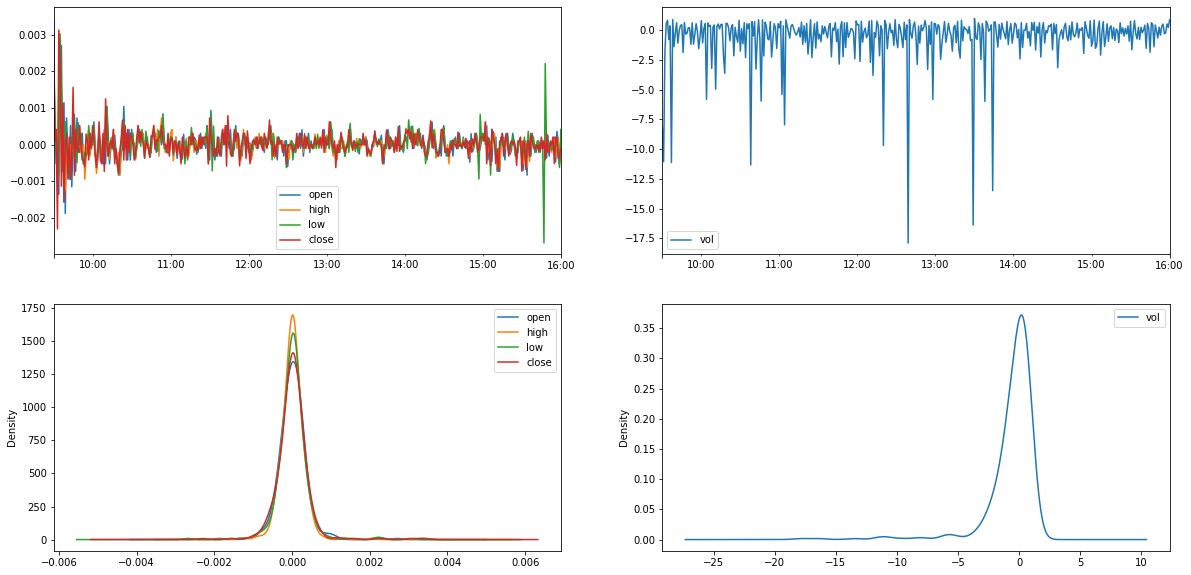

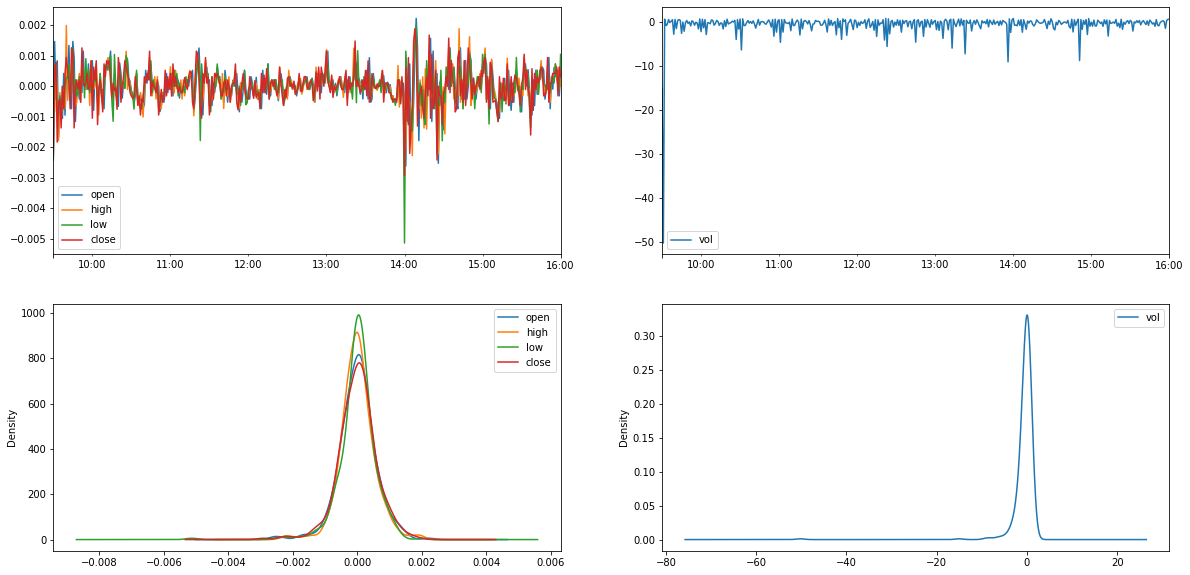

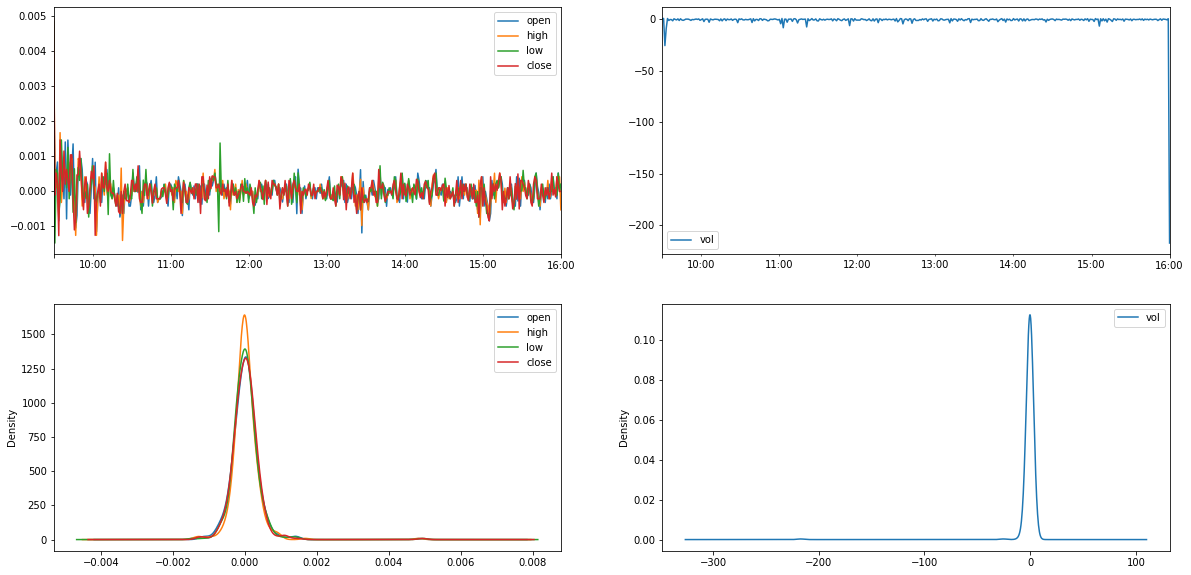

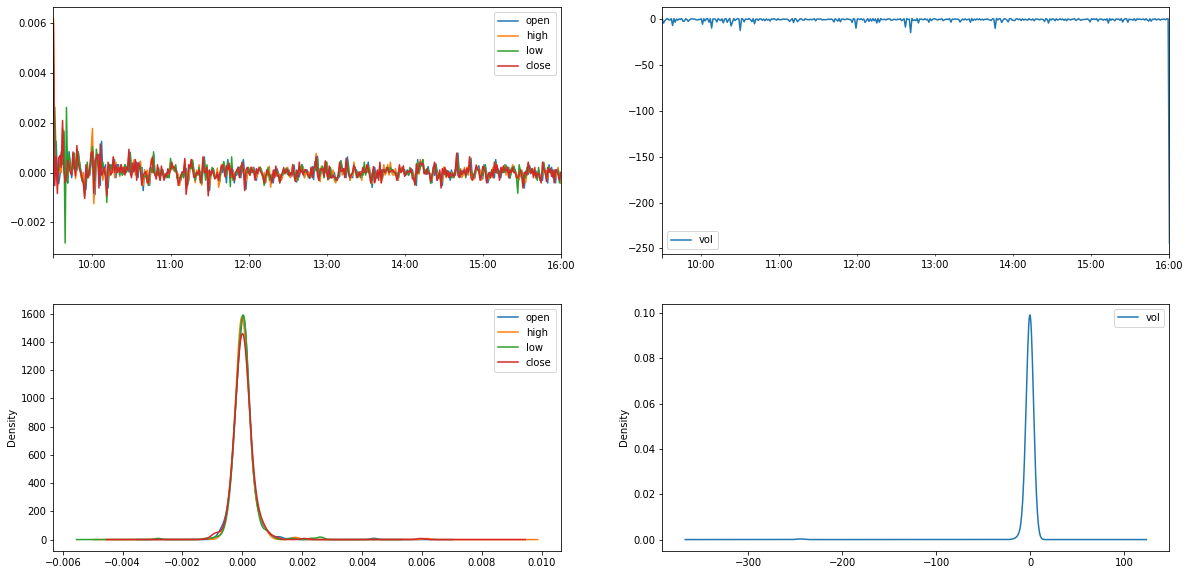

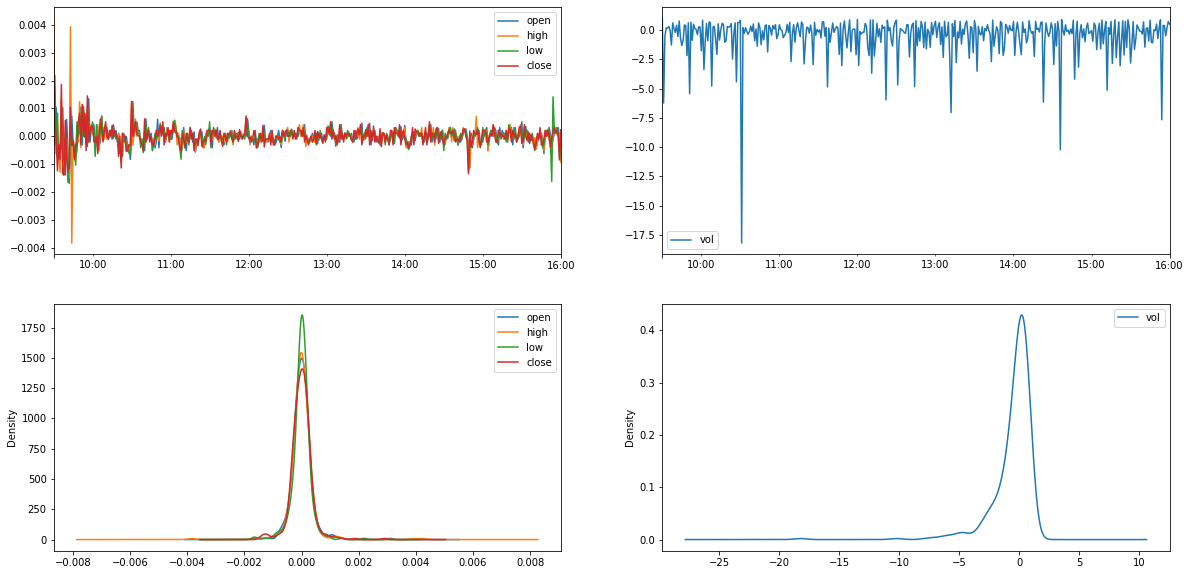

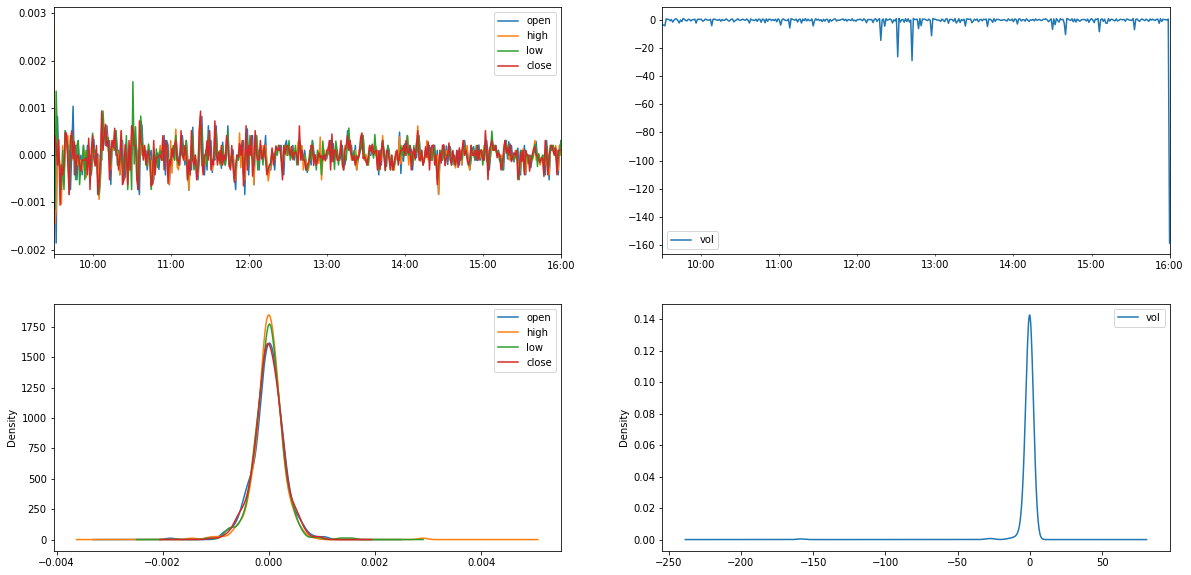

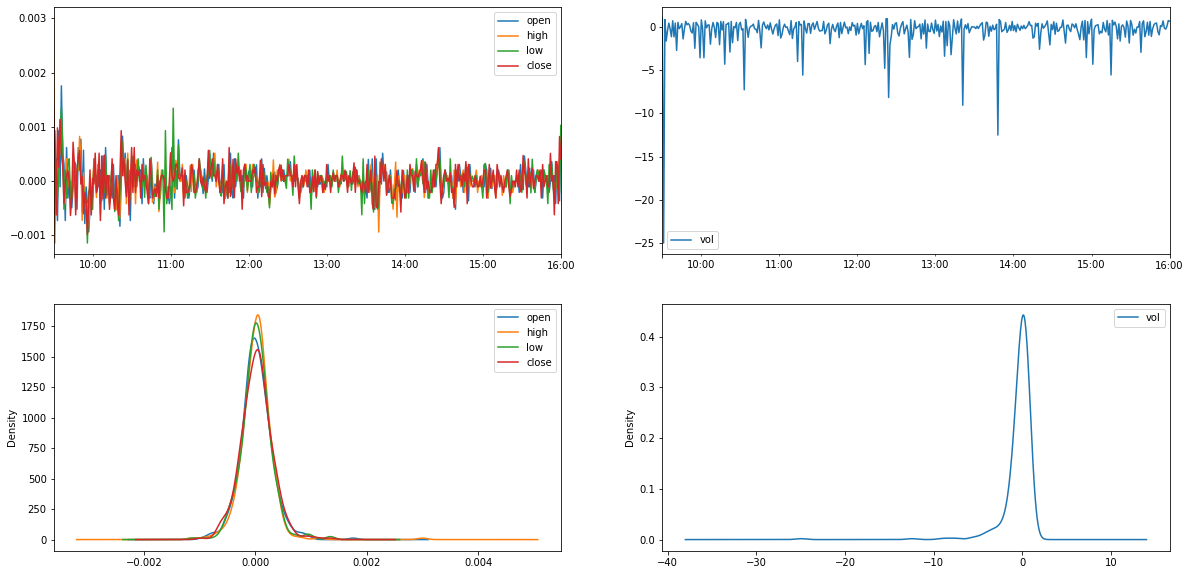

In [48]:
diff1 = delta(aapl_binned)
#print(diff1)
#plot_data(diff1,period_start,period_end,time_open,time_close,resolution='day')
plot_data(diff1,period_start,period_end,time_open,time_close,'day')

In [ ]:
diff2 = delta(aapl_binned, lambdas=2)
diff3 = delta(aapl_binned, lambdas=3)
diff4 = delta(aapl_binned, lambdas=4)
diff5 = delta(aapl_binned, lambdas=5)

## Model data ##

Create parameters ($X$) and outputs ($Y$). Parameters will be:
 - percent diff in price, calculated as
 
\begin{equation}
    x_n = \frac{p_t-p_{t-\lambda}}{p_{t-\lambda}} \mbox{, where } n=[0,\lambda]
\end{equation}

- percent diff in vol, calculated as
\begin{equation}
    x_n = \frac{v_t-v_{t-\lambda}}{v_{t-\lambda}}
\end{equation}

In [ ]:
## Create numpy arrays 
def pd_to_nparray_time_as_epoch(pd_dfs):
    print(pd_dfs[0]['price']['open'].size)
    nparray = np.empty((pd_dfs[0]['price']['open'].size,1))
    for pd_df in pd_dfs:
        nparray_prices = pd_df['price'].values.astype(float)
        nparray_vol = pd_df['vol'].values.astype(float)
        new_nparray = np.concatenate([nparray_prices,nparray_vol], axis=1)
        nparray = np.concatenate((nparray,new_nparray), axis=1) 
    return nparray

In [ ]:
pd_dfs = [diff1,diff2,diff3,diff4,diff5]
x = pd_to_nparray_time_as_epoch(pd_dfs)[:,1:]

In [ ]:
print(x.shape)

In [ ]:
print(x)
print(type(x))

In [ ]:
def normalize(x):
    x[np.isnan(x)] = 0.0
    print(x.shape)
    print(x)
    print(x.mean(axis=0))
    x = x - x.mean(axis=0)
    print(x.shape)
    print(x)
    norm = np.linalg.norm(x, axis=0)
    print(norm)
    return x/norm

In [ ]:
x_normed = normalize(x)

In [ ]:
print(np.abs(x_normed).sum(axis=0))

## Perform linear regression

In [ ]:
y = aapl_binned['price']['open'].values.astype(float)
num_of_points = x_normed.shape[0]
num_of_features = x_normed.shape[1]
#indicies = np.random.permutation(num_of_points-2) # ignore last index to avoid index past the length of dataset
print(indicies.shape)
training_idx, test_idx = indicies[:60], indicies[60:550]
#training_idx, test_idx = indicies[:int(0.8*len(indicies))], indicies[int(0.8*len(indicies)):]
print(training_idx.shape)
print(test_idx.shape)
x_params = np.concatenate((y[:,np.newaxis], x_normed), axis=1)
x_train, x_test = x_params[training_idx,:], x_params[test_idx,:]
y1_train, y1_test = y[(training_idx+1)], y[(test_idx+1)]
y2_train, y2_test = y[(training_idx+2)], y[(test_idx+2)]
print(x_test.shape)
print(x_test)
print(x_train.shape)

In [ ]:
plt.plot(y)

In [ ]:
lin_regressor1 = LinearRegression()
lin_regressor1.fit(x_train, y1_train)
y1_pred_lin = lin_regressor1.predict(x_test)

lin_regressor2 = LinearRegression()
lin_regressor2.fit(x_train, y2_train)
y2_pred_lin = lin_regressor2.predict(x_test)

In [ ]:
rid_regressor1 = Ridge()
rid_regressor1.fit(x_train, y1_train)
y1_pred_rid = rid_regressor1.predict(x_test)

rid_regressor2 = LinearRegression()
rid_regressor2.fit(x_train, y2_train)
y2_pred_rid = rid_regressor2.predict(x_test)

In [ ]:
def intraday_trade_bot(p_1, p_2, p_1_pred, p_2_pred):
    stock = 0
    profit = 0
    correct = 0
    incorrect = 0
    for i in range(len(p_1)-5):
        if p_2_pred[i] > (p_1_pred[i]*1.001):
            profit-= p_2[i]-p_1[i]
            stock+= 1
        elif p_2_pred[i] < (p_1_pred[i]) and stock > 0:
            profit+=  p_2[i]
            stock-=1
        if (p_2_pred[i] > (p_1_pred[i]*1.001) and p_2[i] > p_1[i]) or (p_2_pred[i] < p_1_pred[i] and p_2[i] < p_1[i]):
            correct+=1 
        else:
            incorrect+=1
    profit+=np.mean(p_2)*stock
    return stock, profit, correct, incorrect

In [ ]:
stock_lin, profit_lin, correct_lin, incorrect_lin = intraday_trade_bot(y1_test,y2_test,y1_pred_lin,y2_pred_lin)
stock_rid, profit_rid, correct_rid, incorrect_rid = intraday_trade_bot(y1_test,y2_test,y1_pred_rid,y2_pred_rid)

In [ ]:
plt.plot(y_test,y_pred, 'x')

In [ ]:

stock_rid, profit_rid, correct_rid, incorrect_rid

In [ ]:
stock_lin, profit_lin, correct_lin, incorrect_lin